In [1]:
# Scenario Configuration Structure
import numpy as np

k_qi = 1/8000000000

def create_scenario(name, **kwargs):
    """Create a scenario configuration with default values that can be overridden"""
    default_config = {
        'name': name,
        'adjustment_window': 4000,
        'num_blocks': 50000,
        'starting_difficulty': 4137588815064,
        'difficulty_growth_factor': 0.0001,
        'start_k_quai': 545e15,
        'k_quai_alpha': 1/1000,
        'target_qi_percentage': 500,
        'chosen_qi_percentage': 0,
        'qi_choice_alpha': 1/500,
        'quai_choices': 2000,
        'qi_choices': 2000,
        'slip': 0.1,
        'slip_alpha': 1/5,
        'qi_percentage_type': 'linear',  # 'linear', 'constant', 'step', 'custom'
        'qi_percentage_custom': None,  # for custom qi_percentage_series
        
        # Price dynamics parameters
        'quai_price_initial': 0.05,  # Initial price of QUAI
        'qi_price_initial': 1.0,    # Initial price of QI
        'quai_price_type': 'constant',  # 'constant', 'linear', 'volatile', 'custom'
        'qi_price_type': 'constant',    # 'constant', 'linear', 'volatile', 'custom'
        'quai_price_growth': 0.0,       # Growth rate for linear price changes
        'qi_price_growth': 0.0,         # Growth rate for linear price changes
        'quai_price_volatility': 0.0,   # Volatility for random price changes
        'qi_price_volatility': 0.0,     # Volatility for random price changes
        'quai_price_custom': None,      # Custom price series
        'qi_price_custom': None,        # Custom price series
    }
    
    # Override defaults with provided kwargs
    for key, value in kwargs.items():
        if key in default_config:
            default_config[key] = value
        else:
            print(f"Warning: Unknown parameter '{key}' in scenario '{name}'")
    
    return default_config

def generate_qi_percentage_series(config):
    """Generate qi_percentage_series based on configuration"""
    num_blocks = config['num_blocks']
    target_qi = config['target_qi_percentage']
    chosen_qi = config['chosen_qi_percentage']
    
    if config['qi_percentage_type'] == 'linear':
        # Current behavior - linear ramp
        series = np.linspace(chosen_qi, target_qi, 15000).tolist()
        if len(series) < num_blocks:
            series.extend([target_qi] * (num_blocks - len(series)))
        return series[:num_blocks]
    
    elif config['qi_percentage_type'] == 'constant':
        # Constant percentage throughout
        return [chosen_qi] * num_blocks
    
    elif config['qi_percentage_type'] == 'step':
        # Step function at midpoint
        midpoint = num_blocks // 2
        return [chosen_qi] * midpoint + [target_qi] * (num_blocks - midpoint)
    
    elif config['qi_percentage_type'] == 'custom' and config['qi_percentage_custom']:
        # Custom series provided
        series = config['qi_percentage_custom'][:num_blocks]
        if len(series) < num_blocks:
            series.extend([series[-1]] * (num_blocks - len(series)))
        return series
    
    else:
        # Default to linear
        return generate_qi_percentage_series({**config, 'qi_percentage_type': 'linear'})

In [2]:
def generate_price_series(config, token_type):
    """Generate price series for QUAI or QI based on configuration"""
    num_blocks = config['num_blocks']
    
    if token_type == 'quai':
        initial_price = config['quai_price_initial']
        price_type = config['quai_price_type']
        growth_rate = config['quai_price_growth']
        volatility = config['quai_price_volatility']
        custom_series = config['quai_price_custom']
    elif token_type == 'qi':
        initial_price = config['qi_price_initial']
        price_type = config['qi_price_type']
        growth_rate = config['qi_price_growth']
        volatility = config['qi_price_volatility']
        custom_series = config['qi_price_custom']
    else:
        raise ValueError("token_type must be 'quai' or 'qi'")
    
    if price_type == 'constant':
        return [initial_price] * num_blocks
    
    elif price_type == 'linear':
        # Linear growth: price = initial * (1 + growth_rate * t)
        return [initial_price * (1 + growth_rate * t / num_blocks) for t in range(num_blocks)]
    
    elif price_type == 'volatile':
        # Random walk with volatility
        np.random.seed(42)  # For reproducible results
        prices = [initial_price]
        for _ in range(num_blocks - 1):
            # Random percentage change
            change = np.random.normal(0, volatility)
            new_price = prices[-1] * (1 + change)
            new_price = max(new_price, 0.01)  # Prevent negative prices
            prices.append(new_price)
        return prices
    
    elif price_type == 'exponential':
        # Exponential growth: price = initial * exp(growth_rate * t)
        return [initial_price * np.exp(growth_rate * t / num_blocks) for t in range(num_blocks)]
    
    elif price_type == 'sine':
        # Sinusoidal variation: price = initial * (1 + volatility * sin(2*pi*t/period))
        period = num_blocks // 4  # Complete 4 cycles
        return [initial_price * (1 + volatility * np.sin(2 * np.pi * t / period)) for t in range(num_blocks)]
    
    elif price_type == 'custom' and custom_series:
        # Custom price series
        series = custom_series[:num_blocks]
        if len(series) < num_blocks:
            series.extend([series[-1]] * (num_blocks - len(series)))
        return series
    
    else:
        # Default to constant
        return [initial_price] * num_blocks

def calculate_rewards(k_quai, difficulty, quai_price, qi_price, config):
    """Calculate QUAI and QI rewards based on current parameters"""
    import math
    
    # Basic emission calculation: k_quai * log2(difficulty)
    emission_quai = k_quai * math.log2(difficulty)
    emission_qi = k_qi * difficulty
    
    # Calculate USD value of rewards
    quai_reward_usd = emission_quai * quai_price
    qi_reward_usd = emission_qi * qi_price
    
    return {
        'quai_reward': emission_quai,
        'qi_reward': emission_qi,
        'quai_reward_usd': quai_reward_usd,
        'qi_reward_usd': qi_reward_usd,
        'reward_ratio_usd': qi_reward_usd / quai_reward_usd if quai_reward_usd > 0 else 1.0
    }

In [3]:
def run_simulation(config):
    """Run the simulation with given configuration and return results"""
    import numpy as np
    import math
    
    # Extract parameters from config
    adjustment_window = config['adjustment_window']
    num_blocks = config['num_blocks']
    starting_difficulty = config['starting_difficulty']
    difficulty_growth_factor = config['difficulty_growth_factor']
    start_k_quai = config['start_k_quai']
    k_quai_alpha = config['k_quai_alpha']
    target_qi_percentage = config['target_qi_percentage']
    qi_choice_alpha = config['qi_choice_alpha']
    quai_choices = config['quai_choices']
    qi_choices = config['qi_choices']
    slip = config['slip']
    slip_alpha = config['slip_alpha']
    
    # Generate series based on config
    qi_percentage_series = generate_qi_percentage_series(config)
    quai_price_series = generate_price_series(config, 'quai')
    qi_price_series = generate_price_series(config, 'qi')
    
    # Initialize arrays
    block_difficulties = [starting_difficulty]
    d_ema = block_difficulties[0]
    k_quai_series = [start_k_quai]
    d_ema_series = [d_ema]
    d_star_series = [d_ema]
    
    # Initialize reward tracking arrays
    quai_reward_series = []
    qi_reward_series = []
    quai_reward_usd_series = []
    qi_reward_usd_series = []
    reward_ratio_series = []
    
    # Run simulation
    for n in range(0, num_blocks-1):
        # Calculate current rewards
        rewards = calculate_rewards(k_quai_series[n], block_difficulties[n], 
                                  quai_price_series[n], qi_price_series[n], config)
        
        quai_reward_series.append(rewards['quai_reward'])
        qi_reward_series.append(rewards['qi_reward'])
        quai_reward_usd_series.append(rewards['quai_reward_usd'])
        qi_reward_usd_series.append(rewards['qi_reward_usd'])
        reward_ratio_series.append(rewards['reward_ratio_usd'])
        
        # Update d_ema (ema of average block difficulty)
        d_ema = ((adjustment_window-1) * d_ema + block_difficulties[n]) / adjustment_window
        d_ema_series.append(d_ema)

        d_star = d_ema

        # Update d_star based on qi_percentage (user behavior)
        if qi_percentage_series[n] > target_qi_percentage:
            d_star += qi_choice_alpha * (qi_percentage_series[n] - target_qi_percentage) * d_star
        elif qi_percentage_series[n] < target_qi_percentage:
            d_star -= qi_choice_alpha/3 * (target_qi_percentage - qi_percentage_series[n]) * d_star

        # Update d_star based on conversion slip
        if quai_choices > qi_choices:
            d_star -= slip_alpha/3 * (slip * d_star)
        elif quai_choices < qi_choices:
            d_star += slip_alpha * (slip * d_star)
        
        d_star_series.append(d_star)

        # Calculate d_star_mean for k_quai update
        if n >= adjustment_window:
            d_star_mean = np.mean(d_star_series[n-adjustment_window+1:n+1])
        else:
            d_star_mean = np.mean(d_star_series[:n+1])

        # k_quai update formula
        k_quai_new = k_quai_series[-1] + k_quai_series[-1] * k_quai_alpha * (d_star_mean/d_ema - 1)
        k_quai_series.append(k_quai_new)

        # Basic emission calculation: k_quai * log2(difficulty)
        emission_quai = k_quai_new * math.log2(block_difficulties[-1])
        emission_qi = k_qi * block_difficulties[-1]
        
        # Calculate USD value of rewards
        quai_reward_usd = emission_quai * quai_price_series[n]
        qi_reward_usd = emission_qi * qi_price_series[n]

        if quai_reward_usd > qi_reward_usd:
            new_difficulty = block_difficulties[-1] * (1+difficulty_growth_factor)
            block_difficulties.append(new_difficulty)
        elif quai_reward_usd_series[-1] < qi_reward_usd_series[-1]:
            new_difficulty = block_difficulties[-1] * (1-difficulty_growth_factor)
            block_difficulties.append(new_difficulty)
        else:
            block_difficulties.append(block_difficulties[-1])
    
    # Calculate final rewards for last block
    final_rewards = calculate_rewards(k_quai_series[-1], block_difficulties[-1], 
                                    quai_price_series[-1], qi_price_series[-1], config)
    quai_reward_series.append(final_rewards['quai_reward'])
    qi_reward_series.append(final_rewards['qi_reward'])
    quai_reward_usd_series.append(final_rewards['quai_reward_usd'])
    qi_reward_usd_series.append(final_rewards['qi_reward_usd'])
    reward_ratio_series.append(final_rewards['reward_ratio_usd'])
    
    # Calculate metrics
    percentage_change = (k_quai_series[-1] - k_quai_series[0]) * 100 / k_quai_series[0]
    initial_emission = start_k_quai * math.log2(starting_difficulty)
    final_emission = k_quai_series[-1] * math.log2(block_difficulties[-1])
    emission_reduction = (initial_emission - final_emission) / initial_emission
    
    # Return results
    return {
        'config': config,
        'block_difficulties': block_difficulties,
        'k_quai_series': k_quai_series,
        'd_ema_series': d_ema_series,
        'd_star_series': d_star_series,
        'qi_percentage_series': qi_percentage_series,
        'quai_price_series': quai_price_series,
        'qi_price_series': qi_price_series,
        'quai_reward_series': quai_reward_series,
        'qi_reward_series': qi_reward_series,
        'quai_reward_usd_series': quai_reward_usd_series,
        'qi_reward_usd_series': qi_reward_usd_series,
        'reward_ratio_series': reward_ratio_series,
        'metrics': {
            'initial_k_quai': k_quai_series[0],
            'final_k_quai': k_quai_series[-1],
            'percentage_change_k_quai': percentage_change,
            'initial_emission': initial_emission,
            'final_emission': final_emission,
            'emission_reduction_percentage': emission_reduction,
            'final_d_star': d_star_series[-1],
            'final_d_ema': d_ema_series[-1],
            'final_quai_price': quai_price_series[-1],
            'final_qi_price': qi_price_series[-1],
            'final_reward_ratio': reward_ratio_series[-1],
            'avg_reward_ratio': np.mean(reward_ratio_series)
        }
    }

In [4]:
def plot_scenario_results(results, title_suffix=""):
    """Plot the results of a single scenario simulation"""
    import matplotlib.pyplot as plt
    
    config = results['config']
    num_blocks = config['num_blocks']
    
    fig, axs = plt.subplots(5, 1, figsize=(16, 20), sharex=True)
    
    block_numbers = list(range(num_blocks))
    
    # Plot 1: Block Difficulty and k_quai
    color1 = 'tab:blue'
    color2 = 'tab:green'
    ax1 = axs[0]
    lns1 = ax1.plot(block_numbers, results['block_difficulties'], color=color1, label='Block Difficulty')
    ax1.set_ylabel('Block Difficulty', color=color1)
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1b = ax1.twinx()
    lns2 = ax1b.plot(block_numbers, results['k_quai_series'], color=color2, label='k_quai')
    ax1b.set_ylabel('k_quai', color=color2)
    ax1b.tick_params(axis='y', labelcolor=color2)
    lns = lns1 + lns2
    labels = [l.get_label() for l in lns]
    ax1.legend(lns, labels, loc='upper left')
    ax1.set_title(f'Block Difficulty and k_quai Movement - {config["name"]}{title_suffix}')
    
    # Plot 2: d* and d_ema
    block_numbers_d = list(range(len(results['d_star_series'])))
    ax2 = axs[1]
    ax2.plot(block_numbers_d, results['d_star_series'], label='d* (Target Difficulty)', color='tab:orange')
    ax2.plot(block_numbers_d, results['d_ema_series'], label='d_ema (EMA Difficulty)', color='tab:purple')
    ax2.set_ylabel('Difficulty')
    ax2.set_title(f'd* (Target Difficulty) and d_ema (EMA Difficulty) - {config["name"]}{title_suffix}')
    ax2.legend()
    
    # Plot 3: Price Series
    ax3 = axs[2]
    ax3.plot(block_numbers, results['quai_price_series'], label='QUAI Price', color='tab:blue')
    ax3.plot(block_numbers, results['qi_price_series'], label='QI Price', color='tab:red')
    ax3.set_ylabel('Price (USD)')
    ax3.set_title(f'Token Prices - {config["name"]}{title_suffix}')
    ax3.legend()
    
    # Plot 4: Reward Values (USD)
    ax4 = axs[3]
    ax4.plot(block_numbers, results['quai_reward_usd_series'], label='QUAI Reward (USD)', color='tab:blue')
    ax4.plot(block_numbers, results['qi_reward_usd_series'], label='QI Reward (USD)', color='tab:red')
    ax4.set_ylabel('Reward Value (USD)')
    ax4.set_title(f'Reward Values - {config["name"]}{title_suffix}')
    ax4.legend()
    
    # Create second y-axis for reward ratio
    ax4b = ax4.twinx()
    ax4b.plot(block_numbers, results['reward_ratio_series'], label='QI/QUAI Reward Ratio', 
              color='tab:green', linestyle='--', alpha=0.7)
    ax4b.axhline(y=1.0, color='tab:gray', linestyle=':', alpha=0.5, label='Parity')
    ax4b.set_ylabel('Reward Ratio', color='tab:green')
    ax4b.tick_params(axis='y', labelcolor='tab:green')
    
    # Combine legends
    lines4, labels4 = ax4.get_legend_handles_labels()
    lines4b, labels4b = ax4b.get_legend_handles_labels()
    ax4.legend(lines4 + lines4b, labels4 + labels4b, loc='upper left')
    
    # Plot 5: qi_percentage_series
    ax5 = axs[4]
    ax5.plot(block_numbers, results['qi_percentage_series'], label='qi_percentage', color='tab:red')
    ax5.axhline(y=config['target_qi_percentage'], color='tab:gray', linestyle='--', label='Target qi_percentage')
    ax5.set_xlabel('Block Number')
    ax5.set_ylabel('qi_percentage (basis points)')
    ax5.set_title(f'qi_percentage Over Block Number - {config["name"]}{title_suffix}')
    ax5.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print metrics
    metrics = results['metrics']
    print(f"\n=== {config['name']} Results ===")
    print(f"Initial k_quai: {metrics['initial_k_quai']:.2e}")
    print(f"Final k_quai: {metrics['final_k_quai']:.2e}")
    print(f"Percentage change in k_quai: {metrics['percentage_change_k_quai']:.2f}%")
    print(f"Initial emission per block: {metrics['initial_emission']:.2e}")
    print(f"Final emission per block: {metrics['final_emission']:.2e}")
    print(f"Emission reduction: {metrics['emission_reduction_percentage']:.2f}%")
    print(f"Final QUAI price: ${metrics['final_quai_price']:.4f}")
    print(f"Final QI price: ${metrics['final_qi_price']:.4f}")
    print(f"Final reward ratio (QI/QUAI): {metrics['final_reward_ratio']:.4f}")
    print(f"Average reward ratio: {metrics['avg_reward_ratio']:.4f}")

def compare_scenarios(results_list, metrics_to_compare=None):
    """Compare multiple scenario results in a summary table"""
    import pandas as pd
    
    if metrics_to_compare is None:
        metrics_to_compare = ['final_k_quai', 'percentage_change_k_quai', 
                            'emission_reduction_percentage', 'final_reward_ratio', 'avg_reward_ratio']
    
    comparison_data = []
    for results in results_list:
        row = {'Scenario': results['config']['name']}
        for metric in metrics_to_compare:
            if metric in results['metrics']:
                value = results['metrics'][metric]
                if metric.endswith('_percentage'):
                    row[metric] = f"{value:.2f}%"
                elif 'ratio' in metric:
                    row[metric] = f"{value:.4f}"
                else:
                    row[metric] = f"{value:.2e}"
        comparison_data.append(row)
    
    df = pd.DataFrame(comparison_data)
    return df

In [5]:
# Define scenarios with price dynamics included
scenarios = [
    # Original scenarios with constant prices (baseline)
    create_scenario("Baseline - Constant Prices", 
                   qi_percentage_type='linear'),
    
    # Price dynamics scenarios
    create_scenario("QI Price Rising", 
                   qi_price_type='linear',
                   qi_price_growth=1.0,  # QI price doubles over simulation
                   qi_percentage_type='linear'),
    
    create_scenario("QUAI Price Rising", 
                   quai_price_type='linear',
                   quai_price_growth=1.0,  # QUAI price doubles
                   qi_percentage_type='linear'),
    
    create_scenario("Both Prices Rising", 
                   quai_price_type='linear',
                   qi_price_type='linear',
                   quai_price_growth=0.5,
                   qi_price_growth=0.5,
                   qi_percentage_type='linear'),
    
    create_scenario("QI Premium (2x QUAI price)", 
                   qi_price_initial=2.0,  # QI starts at 2x QUAI price
                   qi_percentage_type='linear'),
    
    create_scenario("Volatile QI Price", 
                   qi_price_type='volatile',
                   qi_price_volatility=0.05,  # 5% daily volatility
                   qi_percentage_type='linear'),
    
    create_scenario("Volatile Both Prices", 
                   quai_price_type='volatile',
                   qi_price_type='volatile',
                   quai_price_volatility=0.03,
                   qi_price_volatility=0.05,
                   qi_percentage_type='linear'),
    
    create_scenario("QI Price Crash", 
                   qi_price_type='linear',
                   qi_price_growth=-0.5,  # QI price halves
                   qi_percentage_type='linear'),
    
    create_scenario("Sinusoidal Price Cycles", 
                   quai_price_type='sine',
                   qi_price_type='sine',
                   quai_price_volatility=0.2,  # 20% amplitude
                   qi_price_volatility=0.3,    # 30% amplitude
                   qi_percentage_type='linear'),
    
    # Extreme scenarios
    create_scenario("QI 10x Premium", 
                   qi_price_initial=10.0,
                   qi_percentage_type='linear'),
    
    create_scenario("High Price Volatility", 
                   quai_price_type='volatile',
                   qi_price_type='volatile',
                   quai_price_volatility=0.1,  # 10% volatility
                   qi_price_volatility=0.15,   # 15% volatility
                   qi_percentage_type='linear'),
    
    # Combined scenarios
    create_scenario("Rising QI + High Responsiveness", 
                   qi_price_type='linear',
                   qi_price_growth=2.0,  # QI price triples
                   k_quai_alpha=1/100,   # High responsiveness
                   qi_percentage_type='linear'),
    
    # Quick test scenario for development
    create_scenario("Quick Price Test", 
                   num_blocks=10000,
                   qi_price_type='linear',
                   qi_price_growth=1.0,
                   qi_percentage_type='linear')
]

print(f"Defined {len(scenarios)} scenarios with price dynamics:")
for i, scenario in enumerate(scenarios, 1):
    quai_price_info = f"QUAI: {scenario['quai_price_type']}"
    qi_price_info = f"QI: {scenario['qi_price_type']}"
    if scenario['quai_price_type'] != 'constant' or scenario['qi_price_type'] != 'constant':
        print(f"{i:2d}. {scenario['name']} ({quai_price_info}, {qi_price_info})")
    else:
        print(f"{i:2d}. {scenario['name']}")

Defined 13 scenarios with price dynamics:
 1. Baseline - Constant Prices
 2. QI Price Rising (QUAI: constant, QI: linear)
 3. QUAI Price Rising (QUAI: linear, QI: constant)
 4. Both Prices Rising (QUAI: linear, QI: linear)
 5. QI Premium (2x QUAI price)
 6. Volatile QI Price (QUAI: constant, QI: volatile)
 7. Volatile Both Prices (QUAI: volatile, QI: volatile)
 8. QI Price Crash (QUAI: constant, QI: linear)
 9. Sinusoidal Price Cycles (QUAI: sine, QI: sine)
10. QI 10x Premium
11. High Price Volatility (QUAI: volatile, QI: volatile)
12. Rising QI + High Responsiveness (QUAI: constant, QI: linear)
13. Quick Price Test (QUAI: constant, QI: linear)


In [6]:
def run_all_scenarios(scenarios, plot_each=True, show_comparison=True):
    """Run all scenarios and optionally plot results and show comparison"""
    results_list = []
    
    print("Running scenarios...")
    for i, scenario in enumerate(scenarios, 1):
        print(f"Running scenario {i}/{len(scenarios)}: {scenario['name']}...")
        results = run_simulation(scenario)
        results_list.append(results)
        
        if plot_each:
            plot_scenario_results(results)
    
    if show_comparison:
        print("\n" + "="*80)
        print("SCENARIO COMPARISON")
        print("="*80)
        comparison_df = compare_scenarios(results_list)
        print(comparison_df.to_string(index=False))
    
    return results_list

def run_specific_scenarios(scenario_indices, scenarios=None):
    """Run specific scenarios by index"""
    if scenarios is None:
        scenarios = globals()['scenarios']  # Use the global scenarios list
    
    selected_scenarios = [scenarios[i] for i in scenario_indices]
    return run_all_scenarios(selected_scenarios)

# Updated example usage functions for price dynamics:
def run_price_test():
    """Run just the quick price test scenario"""
    return run_specific_scenarios([12])  # Quick Price Test

def run_price_comparison():
    """Compare different price scenarios"""
    return run_specific_scenarios([0, 1, 2, 4])  # Baseline, QI Rising, QUAI Rising, QI Premium

def run_volatility_scenarios():
    """Compare volatility scenarios"""
    return run_specific_scenarios([0, 5, 6, 10])  # Baseline, Volatile QI, Volatile Both, High Volatility

def run_extreme_scenarios():
    """Run extreme price scenarios"""
    return run_specific_scenarios([7, 9, 11])  # QI Crash, QI 10x Premium, Rising QI + High Responsiveness

# Usage Examples with Price Dynamics

Now you can easily run scenarios with price dynamics! Here are some examples:

```python
# Run a quick price test (just 10k blocks with rising QI price)
results = run_price_test()

# Compare different price scenarios
results = run_price_comparison()

# Compare volatility scenarios
results = run_volatility_scenarios()

# Run extreme scenarios
results = run_extreme_scenarios()

# Run all scenarios (warning: takes time and shows lots of plots!)
# results = run_all_scenarios(scenarios, plot_each=True, show_comparison=True)

# Run all scenarios without individual plots (just get comparison table)
# results = run_all_scenarios(scenarios, plot_each=False, show_comparison=True)

# Run specific scenarios by index
# results = run_specific_scenarios([0, 4, 9])  # Baseline, QI Premium, QI 10x Premium

# Run a single scenario
# single_result = run_simulation(scenarios[1])  # QI Price Rising
# plot_scenario_results(single_result)
```

## New Price-Enabled Scenarios:

### **Basic Price Dynamics:**
0. Baseline - Constant Prices (QUAI=QI=$1.00)
1. QI Price Rising (doubles over simulation)
2. QUAI Price Rising (doubles over simulation)  
3. Both Prices Rising (both grow 50%)
4. QI Premium (QI starts at $2.00)

### **Volatility Scenarios:**
5. Volatile QI Price (5% volatility)
6. Volatile Both Prices (3% QUAI, 5% QI volatility)
7. QI Price Crash (halves over simulation)
8. Sinusoidal Price Cycles (oscillating prices)
10. High Price Volatility (10-15% volatility)

### **Extreme Scenarios:**
9. QI 10x Premium (QI starts at $10.00)
11. Rising QI + High Responsiveness (combined effects)

### **Development/Testing:**
12. Quick Price Test (10k blocks, rising QI)

## Key New Features:
- **Price Series**: QUAI and QI prices can follow different patterns (constant, linear, volatile, sine, custom)
- **Reward Calculations**: USD values of rewards based on token prices
- **Market-Driven Difficulty**: Difficulty now adjusts based on reward imbalances
- **Enhanced Plotting**: Shows price series, reward values, and reward ratios
- **Reward Ratio Analysis**: Track when QI vs QUAI mining becomes more profitable

Running scenarios...
Running scenario 1/13: Baseline - Constant Prices...


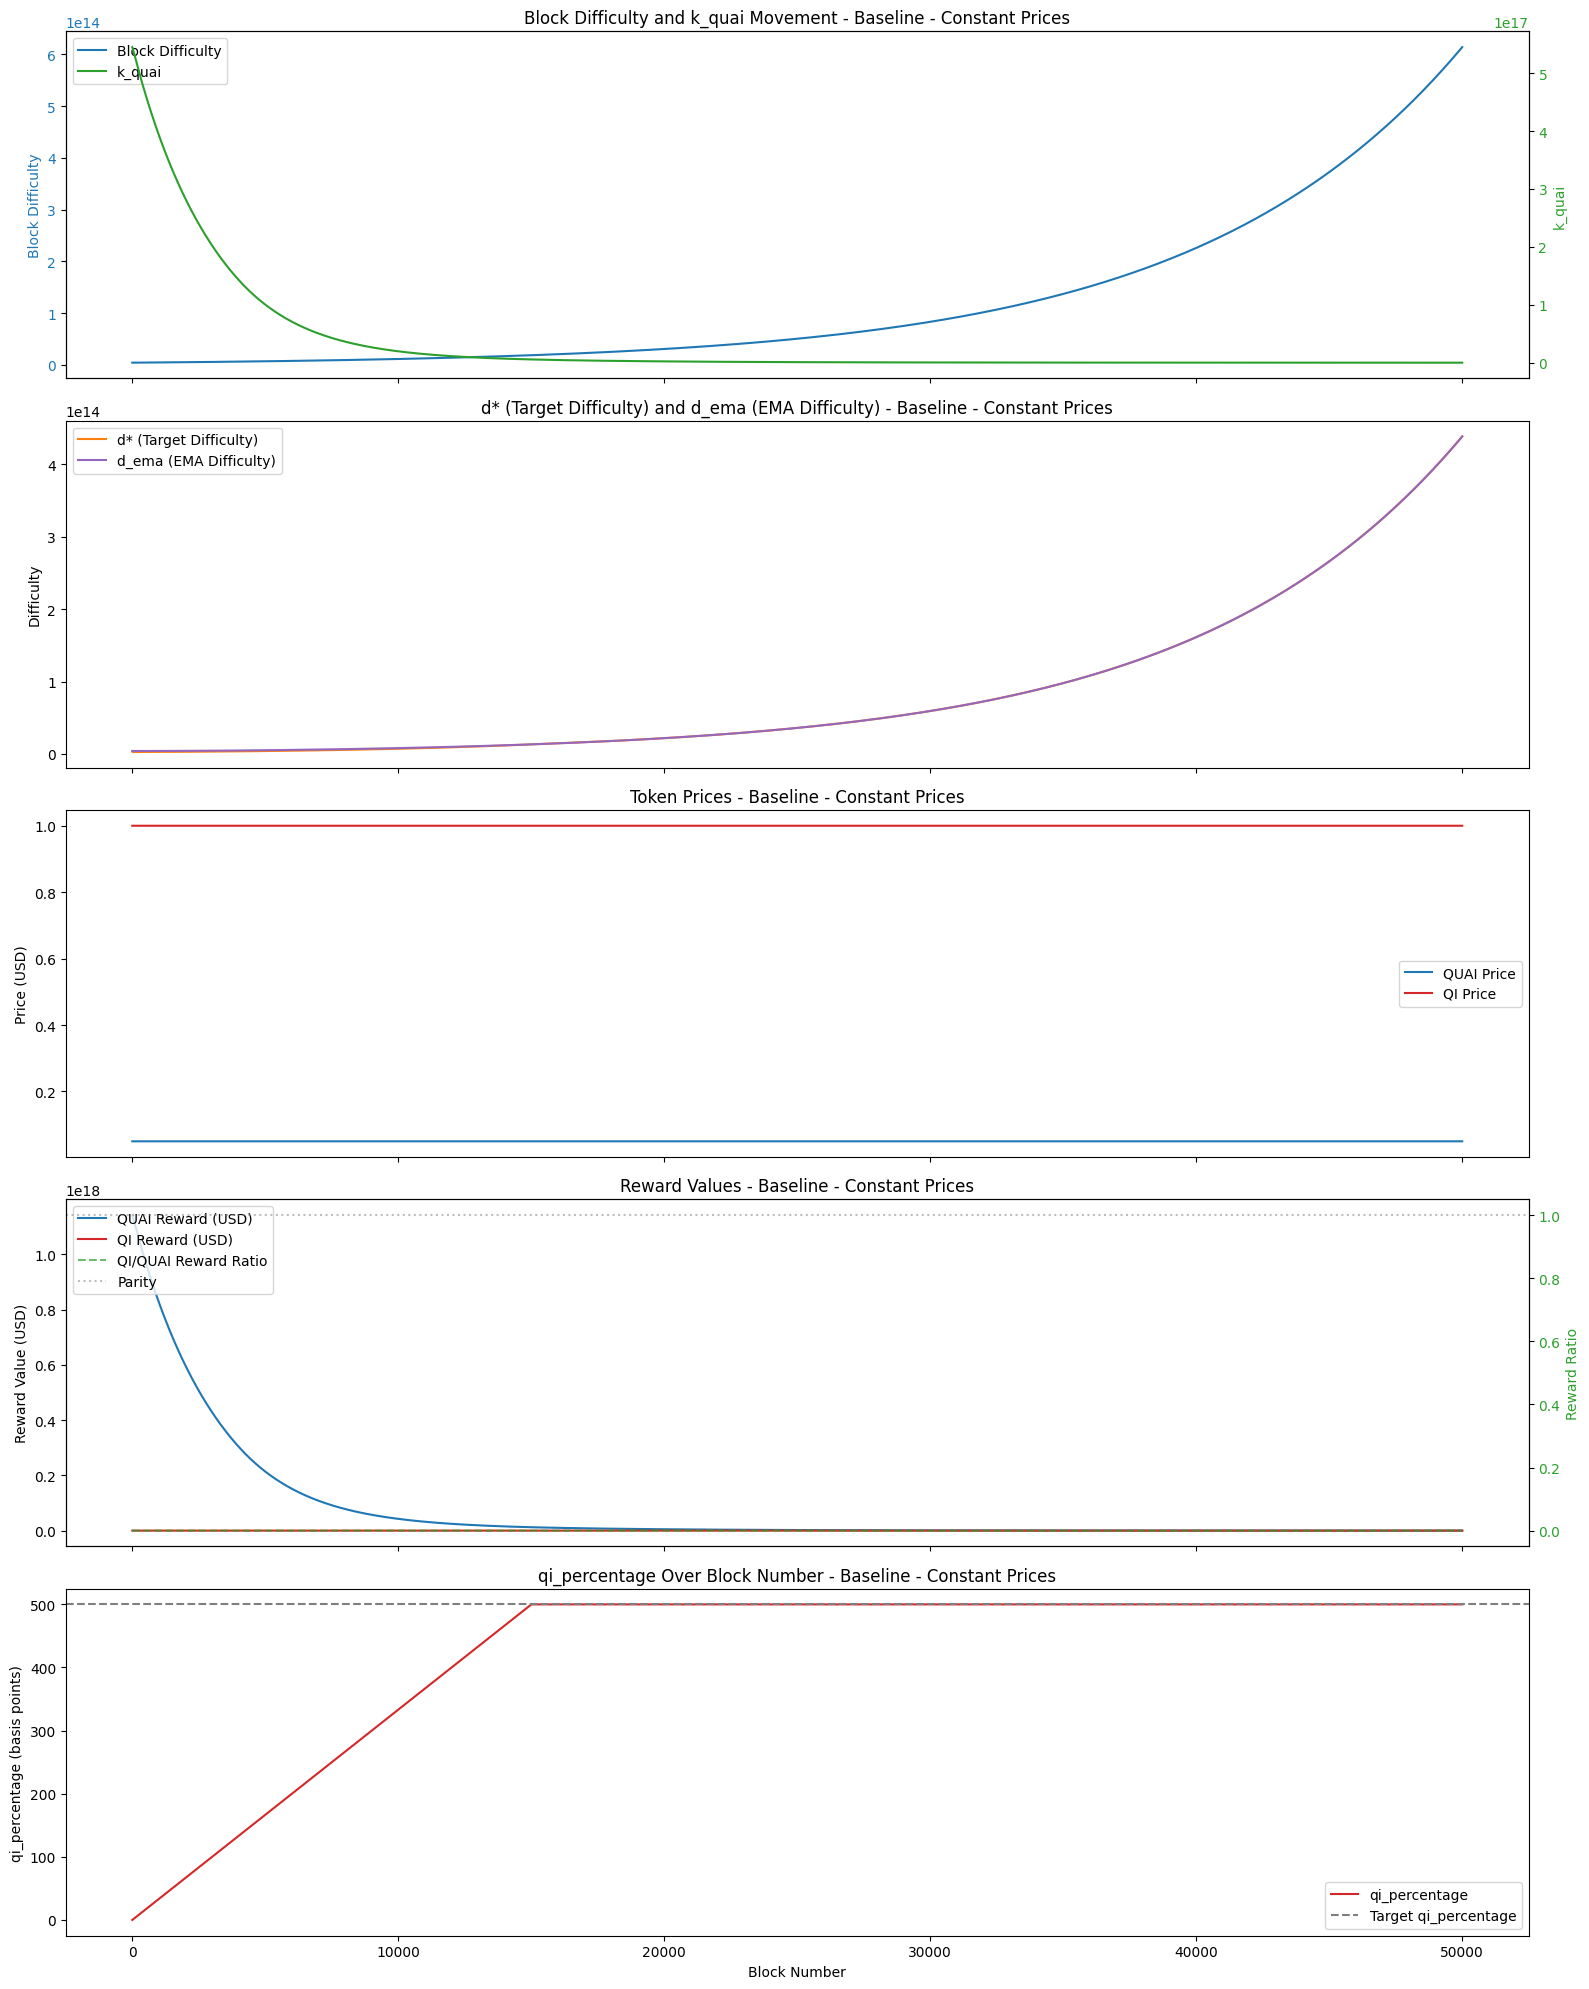


=== Baseline - Constant Prices Results ===
Initial k_quai: 5.45e+17
Final k_quai: 1.14e+13
Percentage change in k_quai: -100.00%
Initial emission per block: 2.28e+19
Final emission per block: 5.60e+14
Emission reduction: 1.00%
Final QUAI price: $0.0500
Final QI price: $1.0000
Final reward ratio (QI/QUAI): 0.0000
Average reward ratio: 0.0000
Running scenario 2/13: QI Price Rising...


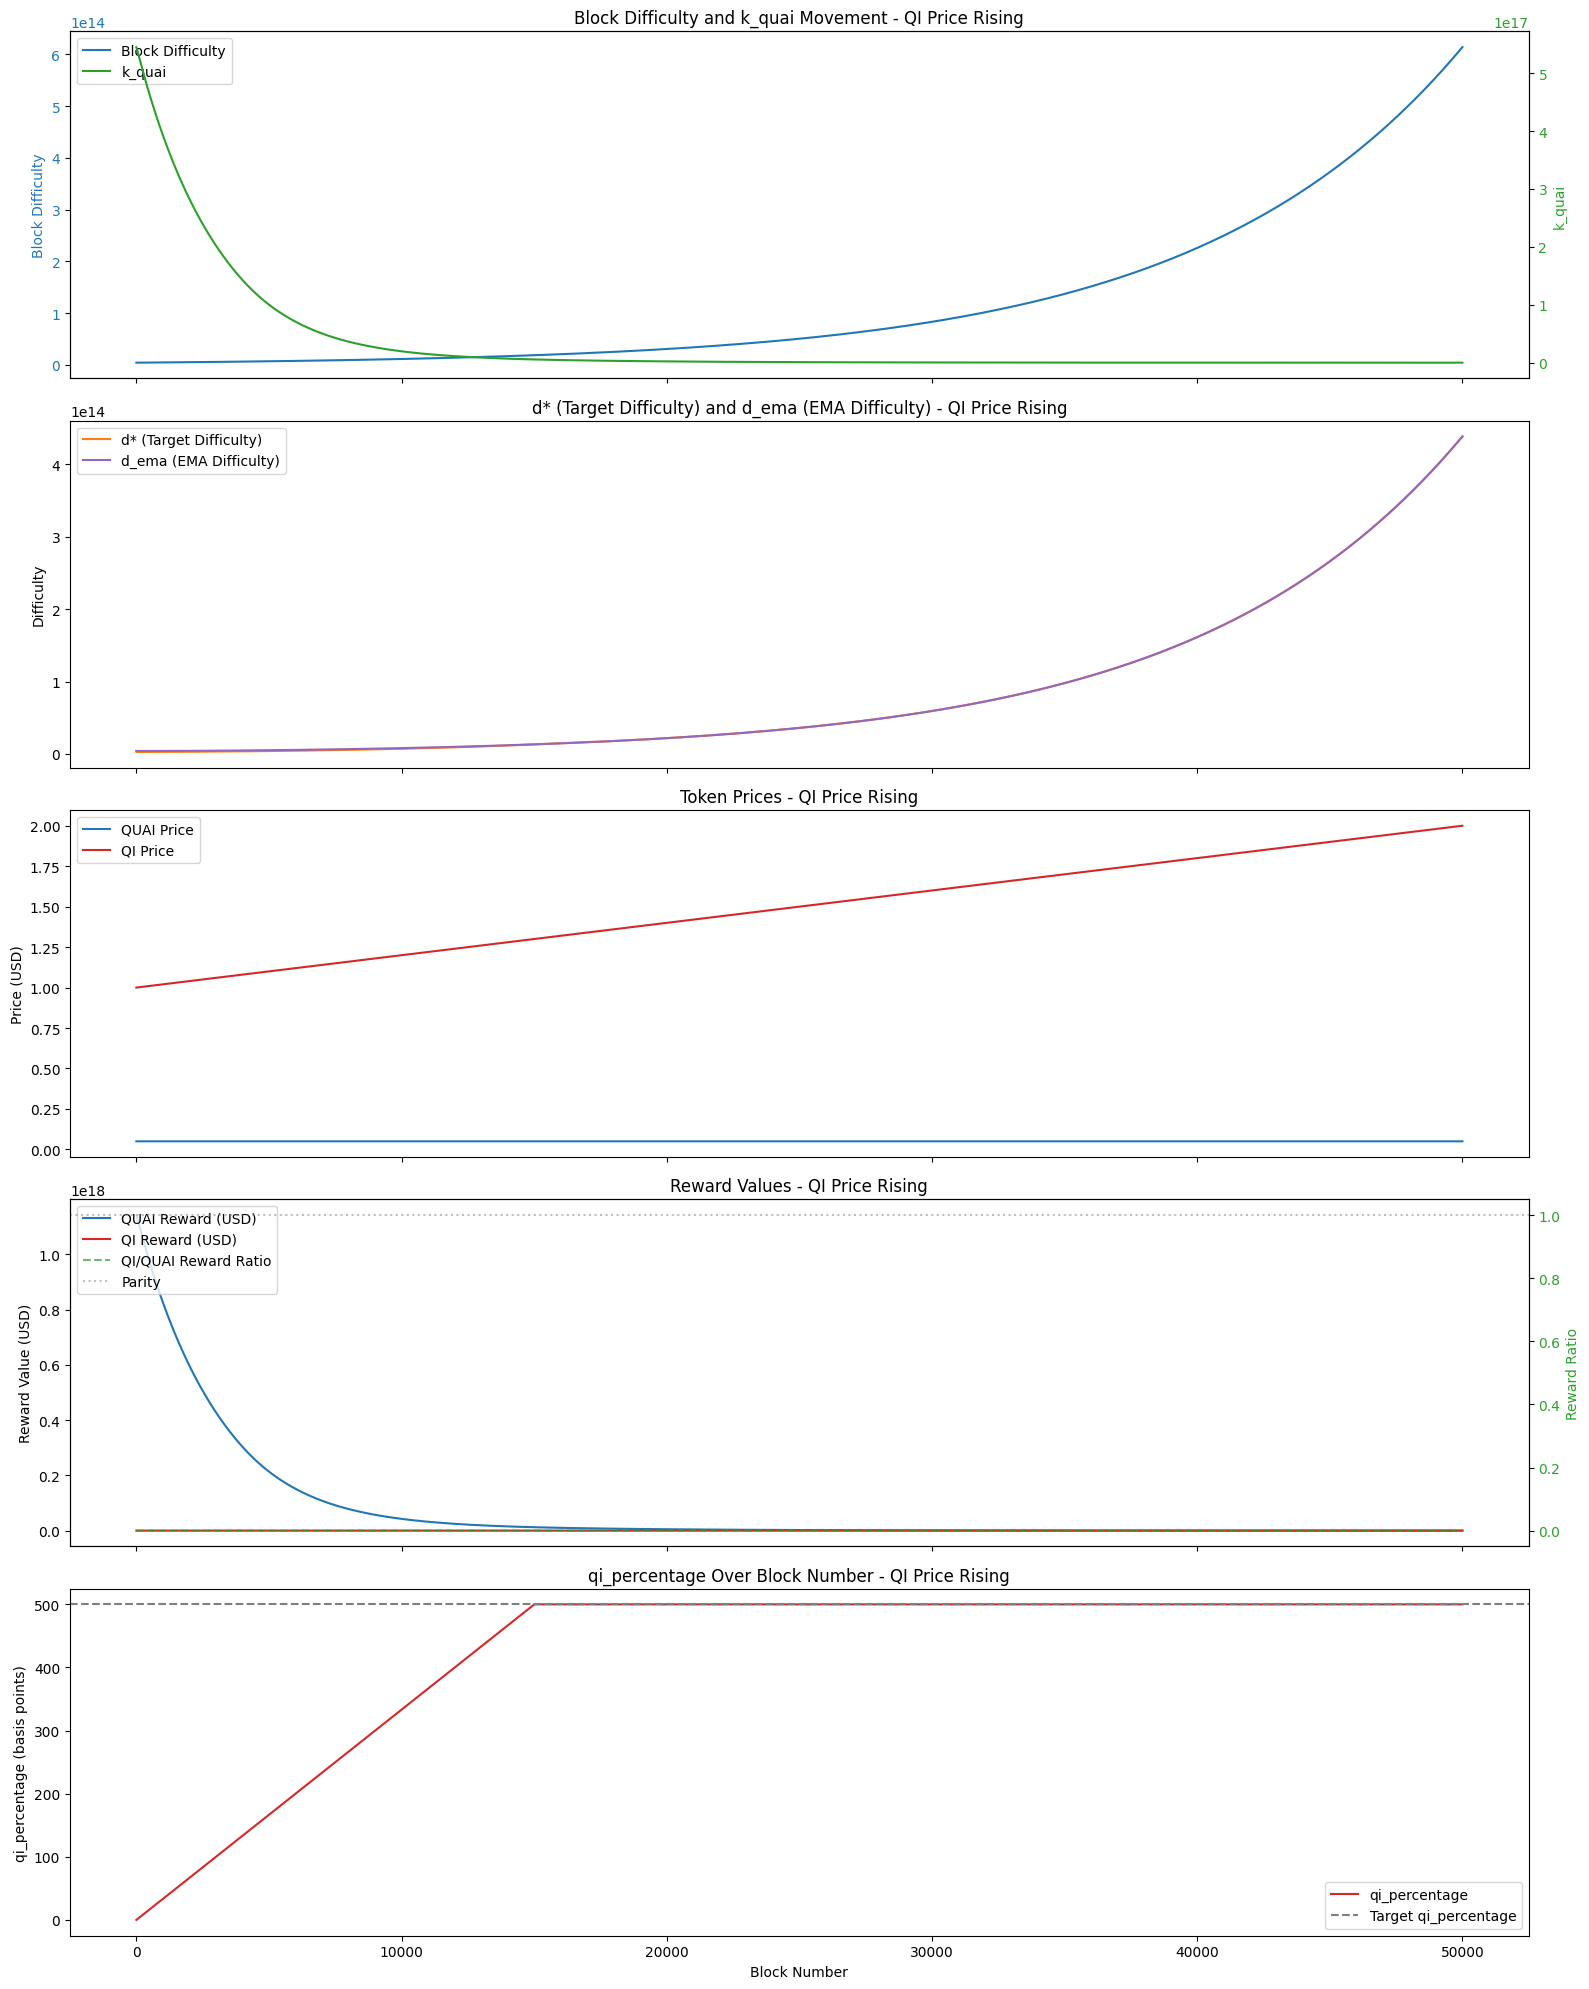


=== QI Price Rising Results ===
Initial k_quai: 5.45e+17
Final k_quai: 1.14e+13
Percentage change in k_quai: -100.00%
Initial emission per block: 2.28e+19
Final emission per block: 5.60e+14
Emission reduction: 1.00%
Final QUAI price: $0.0500
Final QI price: $2.0000
Final reward ratio (QI/QUAI): 0.0000
Average reward ratio: 0.0000
Running scenario 3/13: QUAI Price Rising...


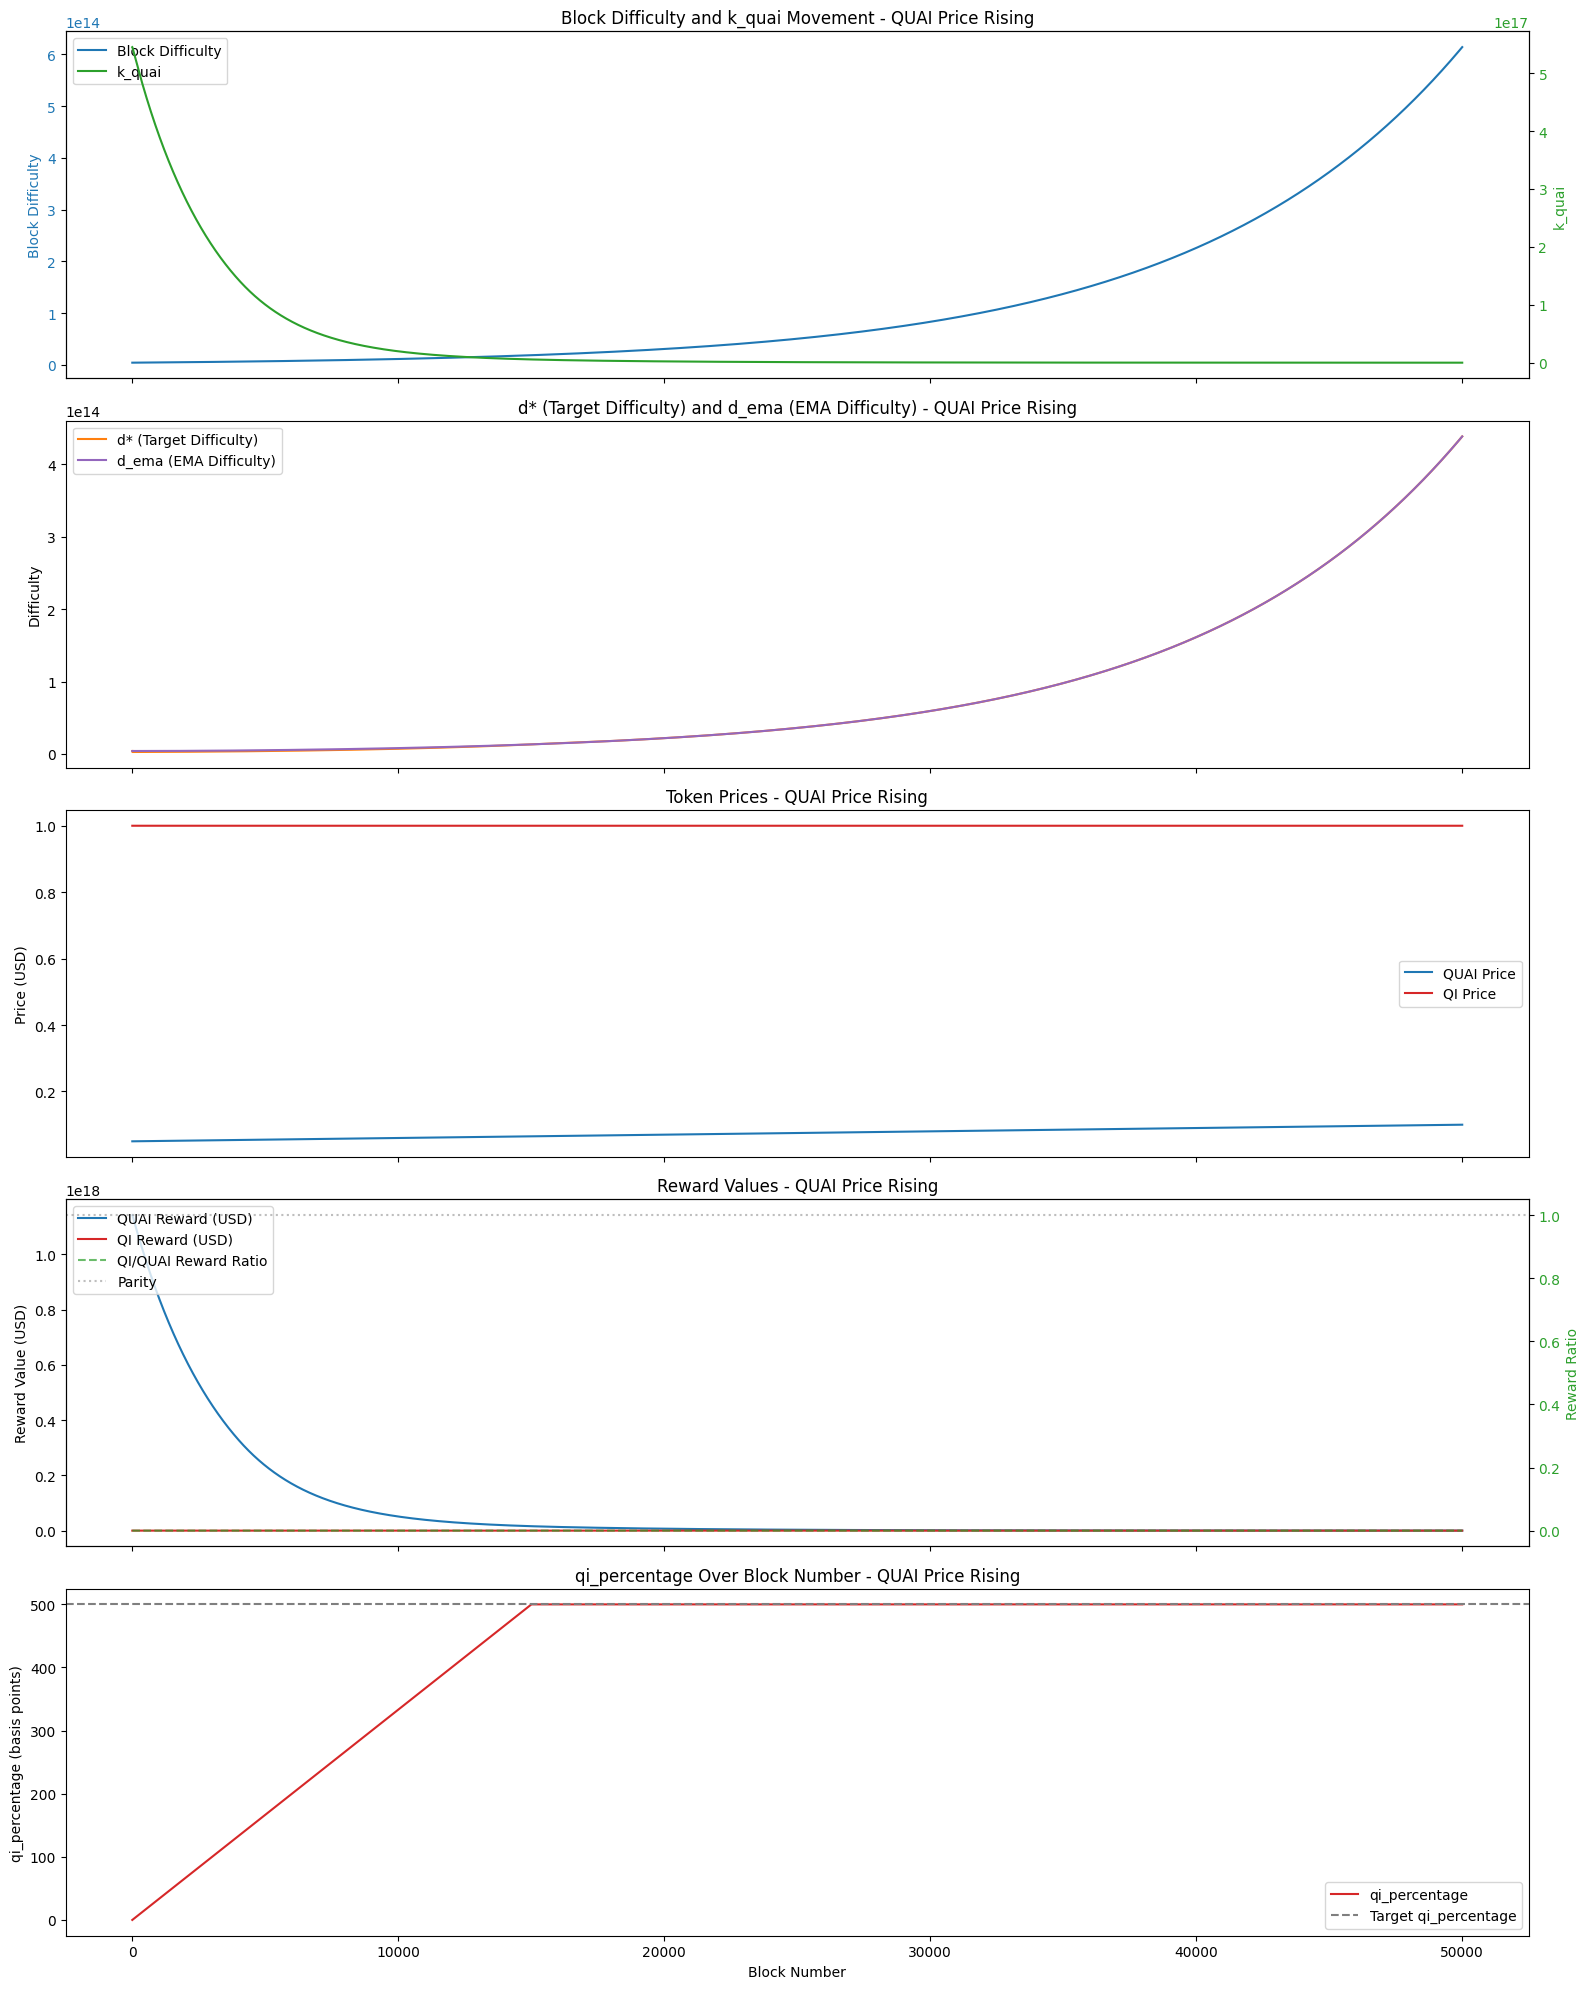


=== QUAI Price Rising Results ===
Initial k_quai: 5.45e+17
Final k_quai: 1.14e+13
Percentage change in k_quai: -100.00%
Initial emission per block: 2.28e+19
Final emission per block: 5.60e+14
Emission reduction: 1.00%
Final QUAI price: $0.1000
Final QI price: $1.0000
Final reward ratio (QI/QUAI): 0.0000
Average reward ratio: 0.0000
Running scenario 4/13: Both Prices Rising...


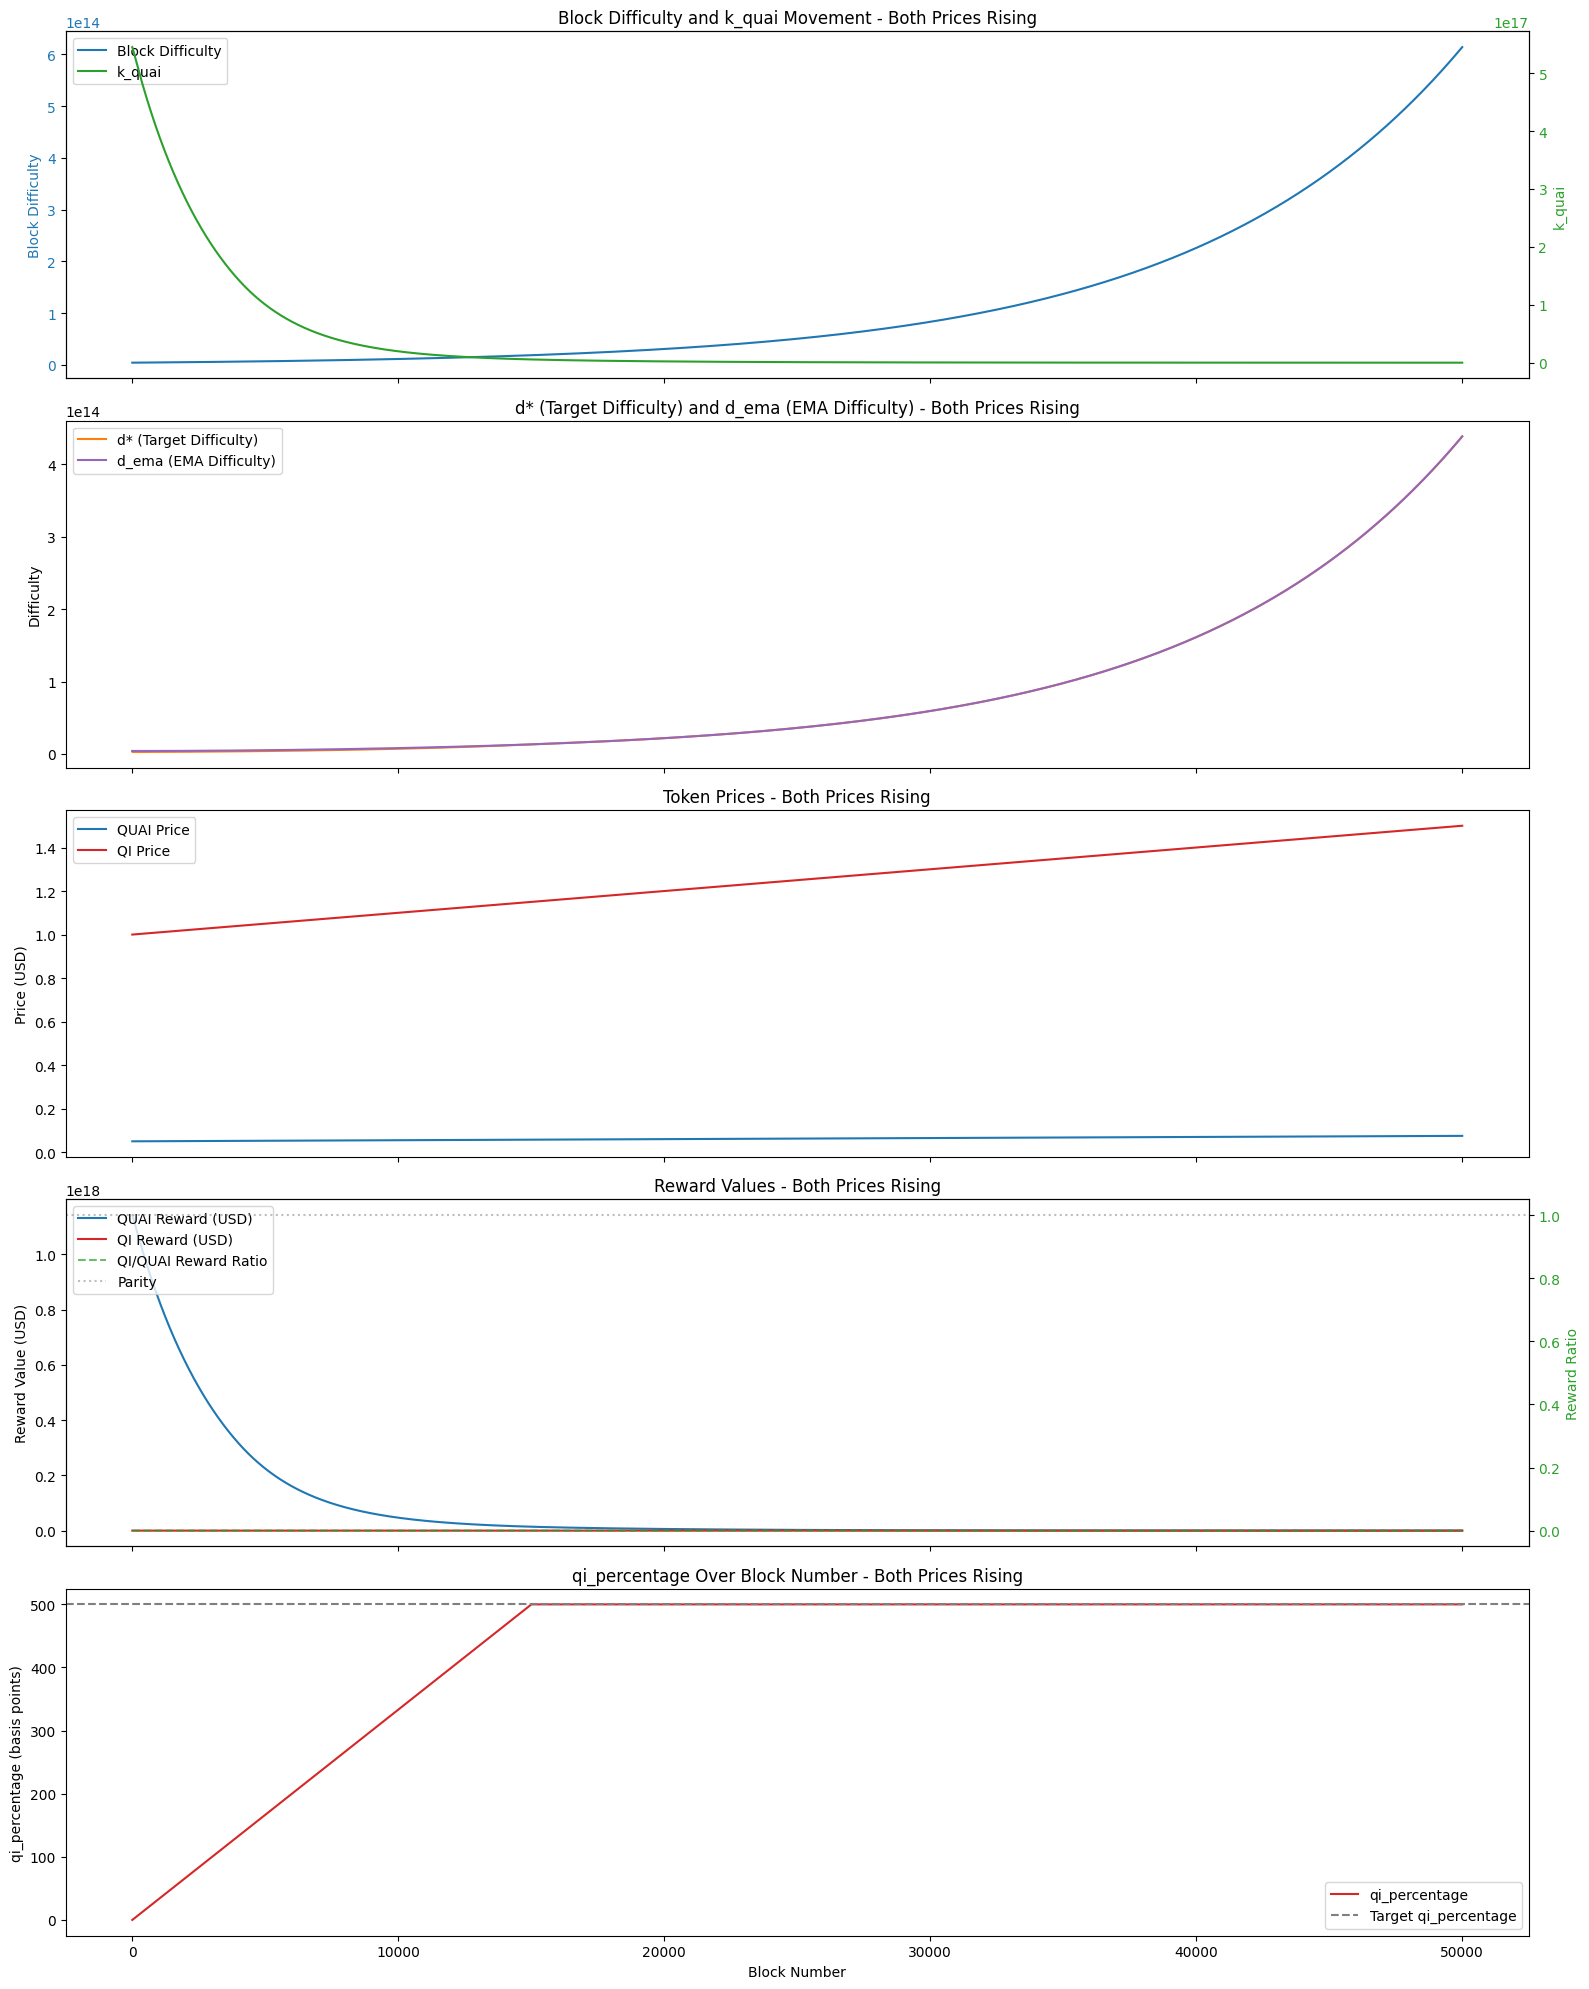


=== Both Prices Rising Results ===
Initial k_quai: 5.45e+17
Final k_quai: 1.14e+13
Percentage change in k_quai: -100.00%
Initial emission per block: 2.28e+19
Final emission per block: 5.60e+14
Emission reduction: 1.00%
Final QUAI price: $0.0750
Final QI price: $1.5000
Final reward ratio (QI/QUAI): 0.0000
Average reward ratio: 0.0000
Running scenario 5/13: QI Premium (2x QUAI price)...


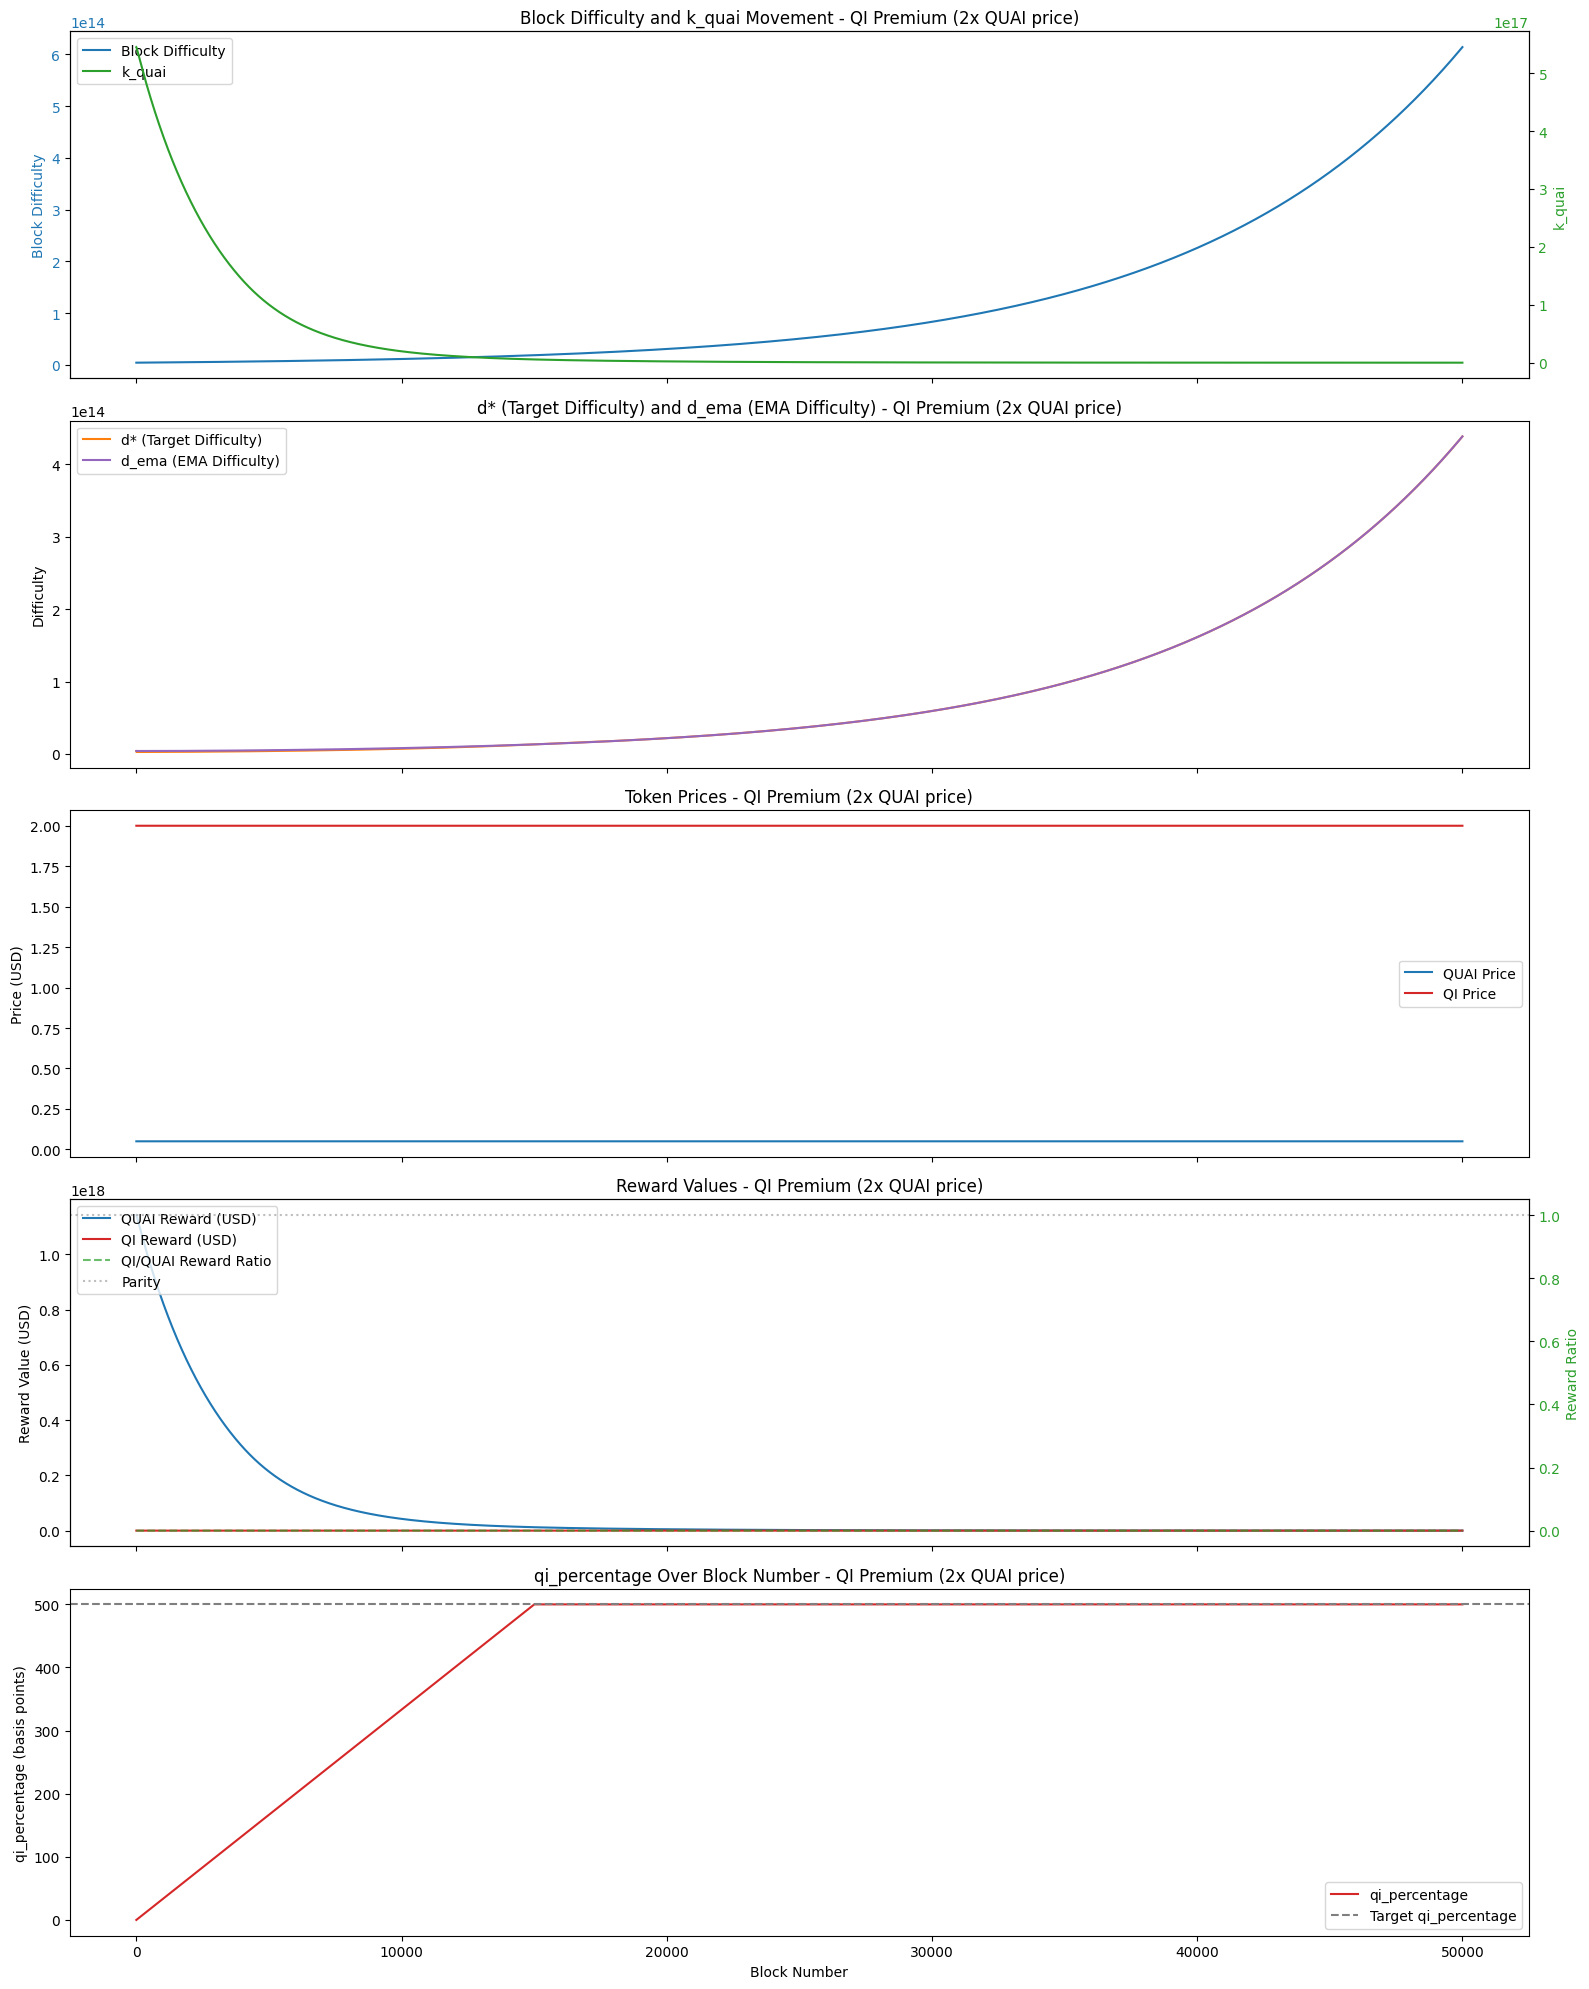


=== QI Premium (2x QUAI price) Results ===
Initial k_quai: 5.45e+17
Final k_quai: 1.14e+13
Percentage change in k_quai: -100.00%
Initial emission per block: 2.28e+19
Final emission per block: 5.60e+14
Emission reduction: 1.00%
Final QUAI price: $0.0500
Final QI price: $2.0000
Final reward ratio (QI/QUAI): 0.0000
Average reward ratio: 0.0000
Running scenario 6/13: Volatile QI Price...


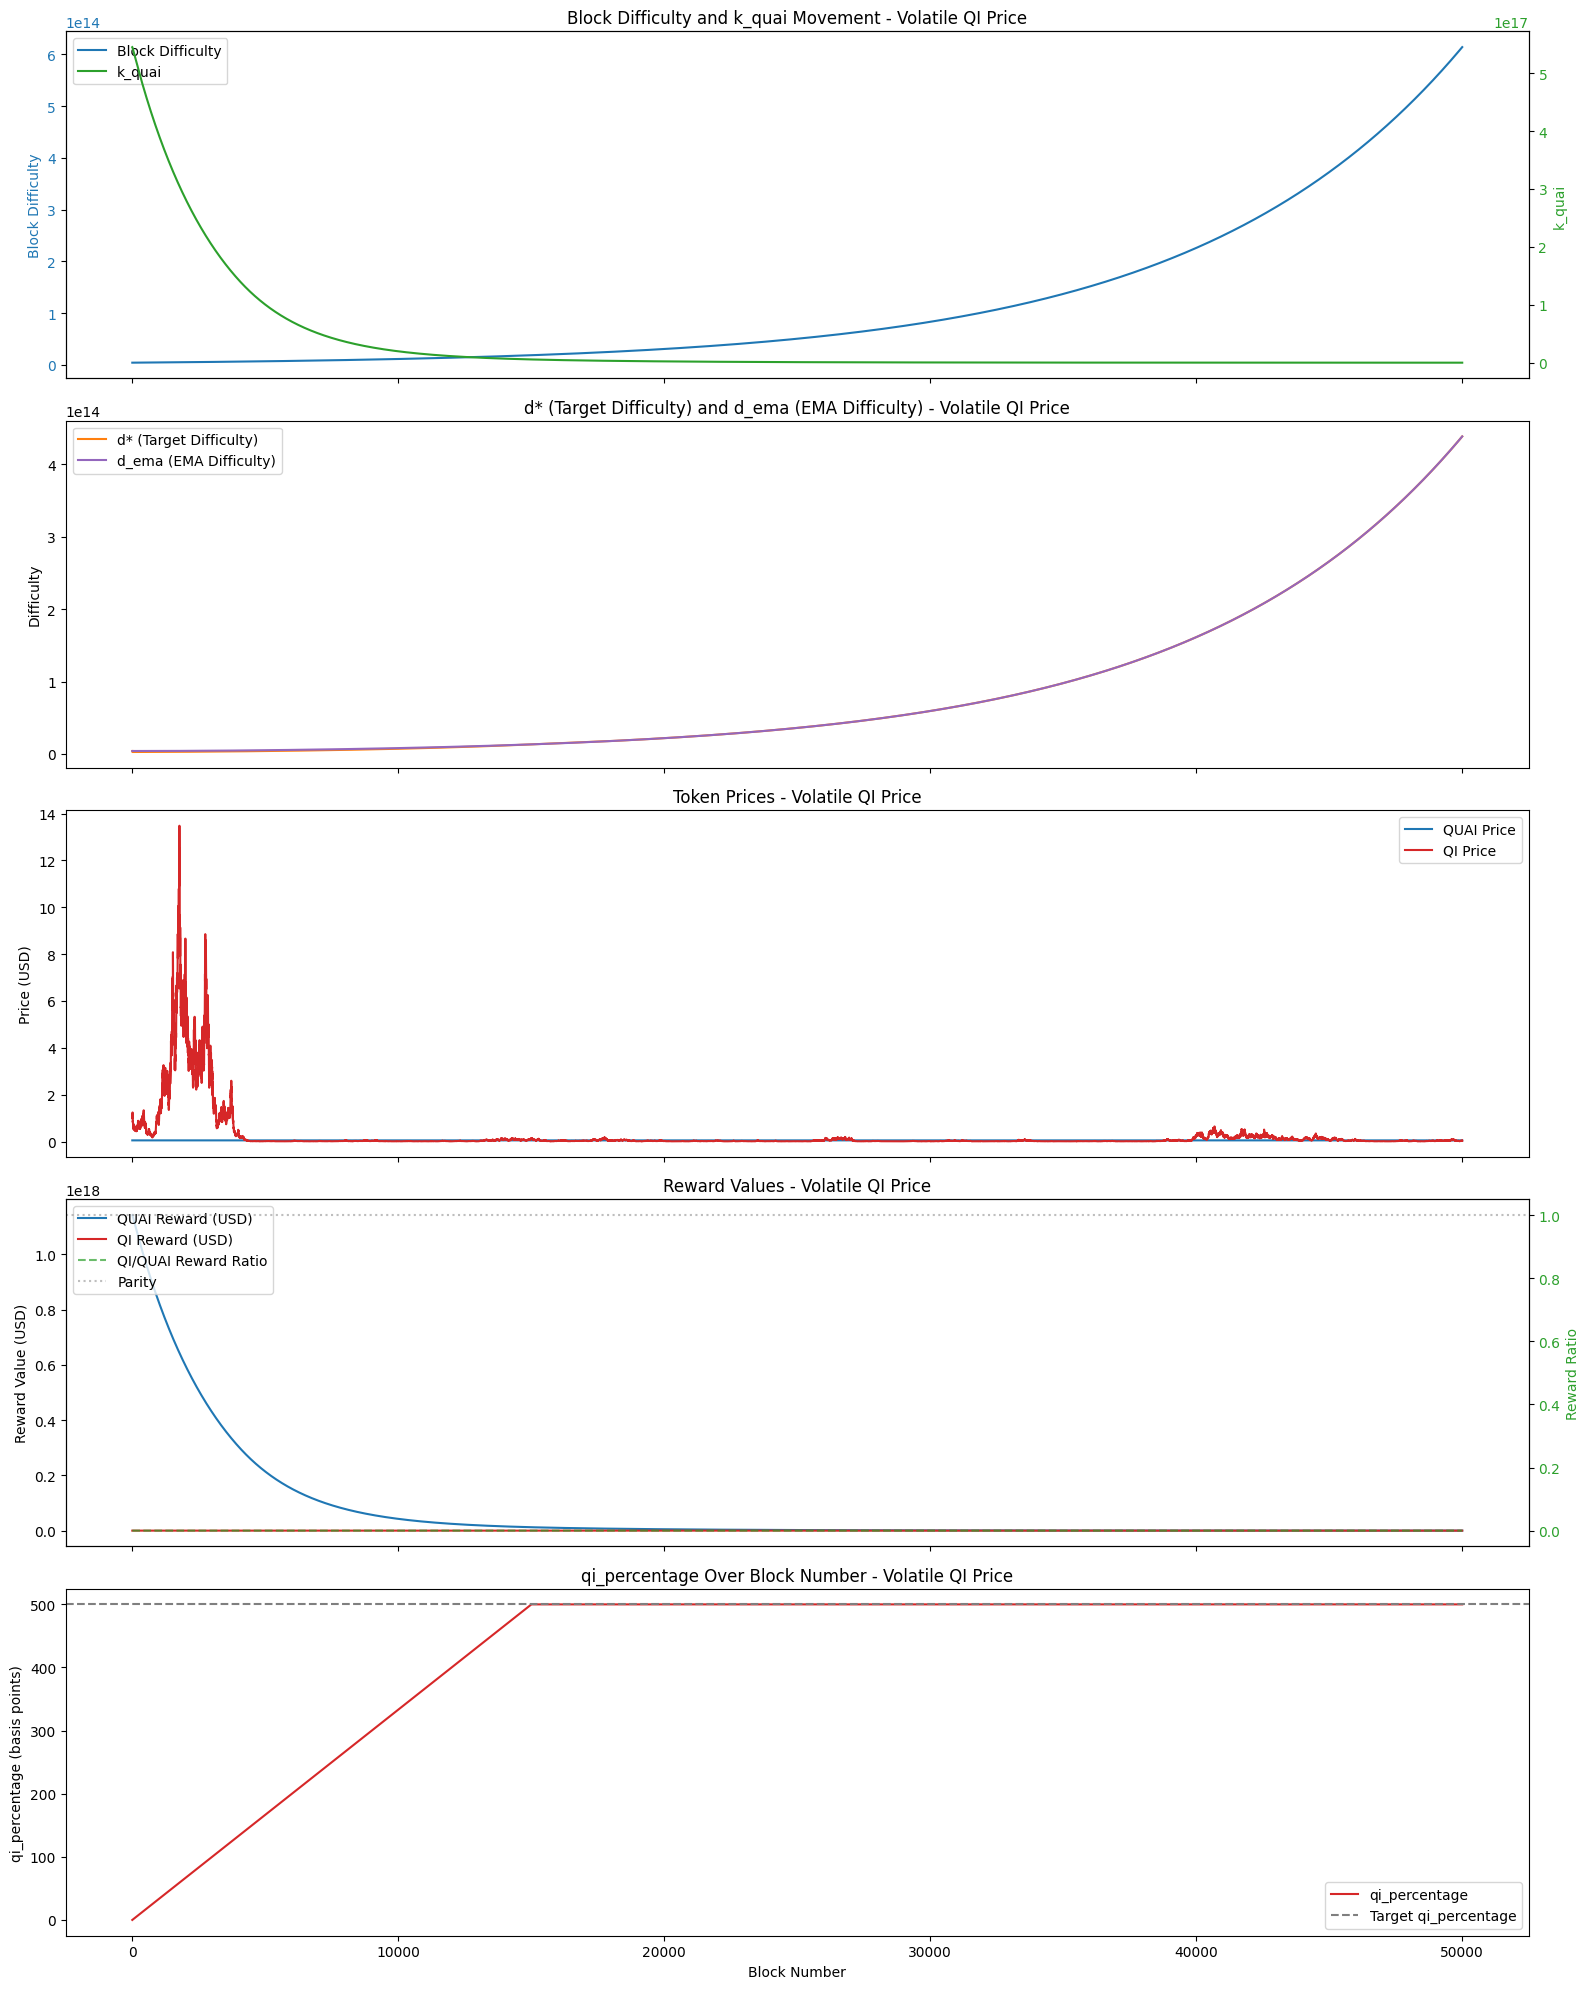


=== Volatile QI Price Results ===
Initial k_quai: 5.45e+17
Final k_quai: 1.14e+13
Percentage change in k_quai: -100.00%
Initial emission per block: 2.28e+19
Final emission per block: 5.60e+14
Emission reduction: 1.00%
Final QUAI price: $0.0500
Final QI price: $0.0367
Final reward ratio (QI/QUAI): 0.0000
Average reward ratio: 0.0000
Running scenario 7/13: Volatile Both Prices...


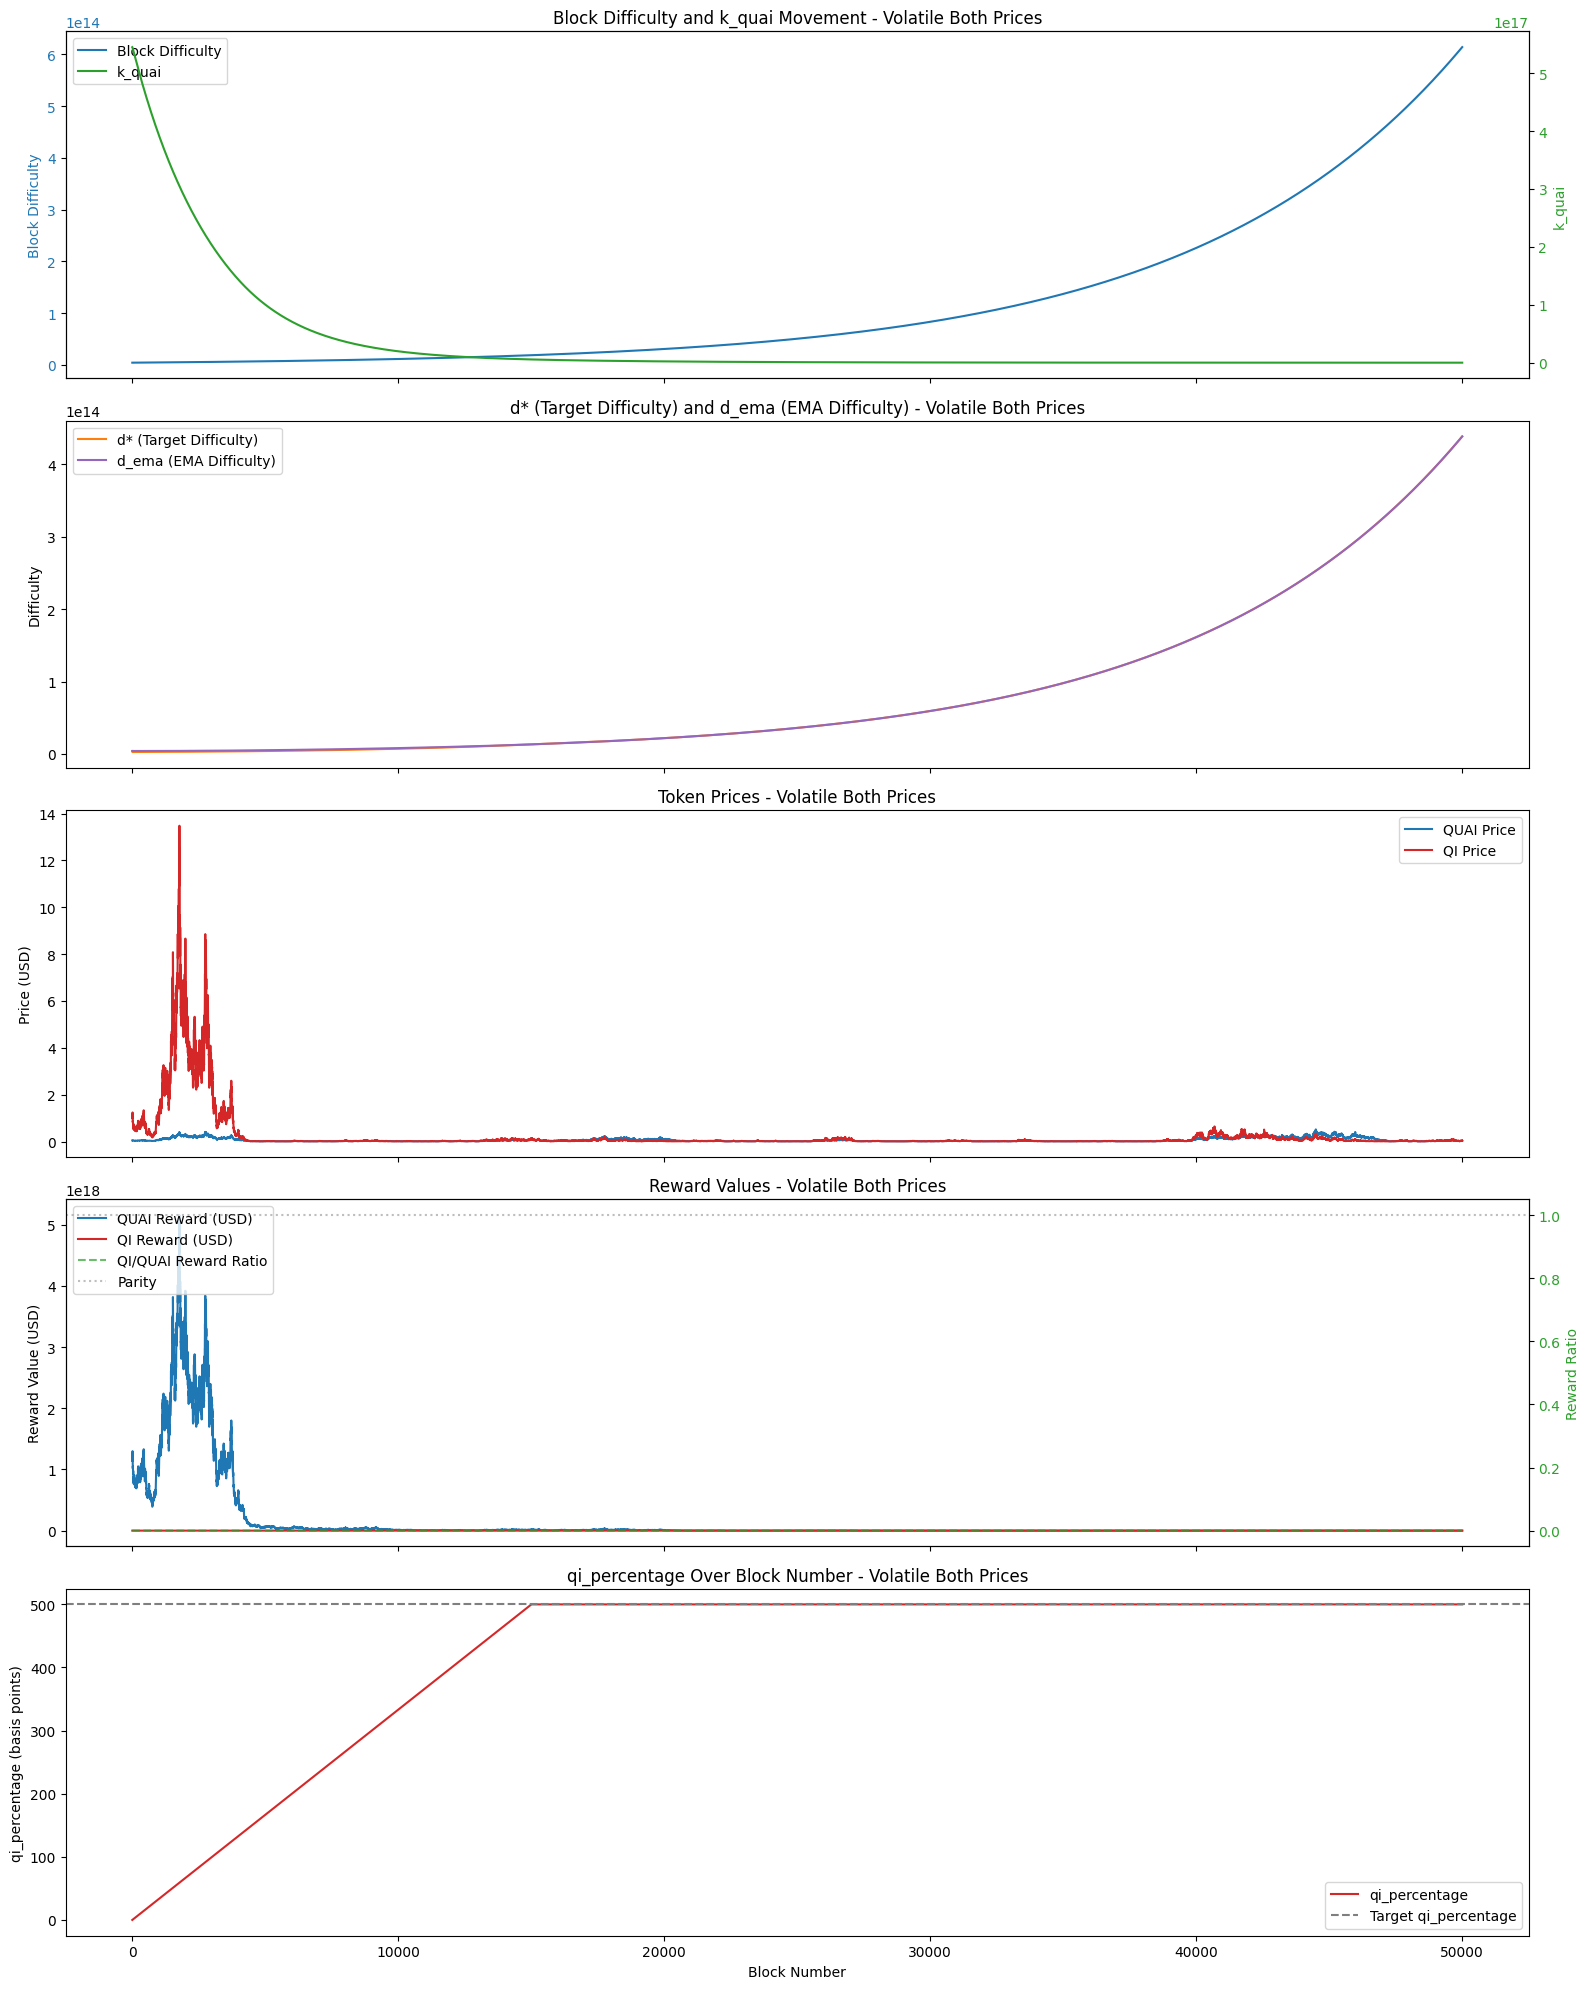


=== Volatile Both Prices Results ===
Initial k_quai: 5.45e+17
Final k_quai: 1.14e+13
Percentage change in k_quai: -100.00%
Initial emission per block: 2.28e+19
Final emission per block: 5.60e+14
Emission reduction: 1.00%
Final QUAI price: $0.0340
Final QI price: $0.0367
Final reward ratio (QI/QUAI): 0.0000
Average reward ratio: 0.0000
Running scenario 8/13: QI Price Crash...


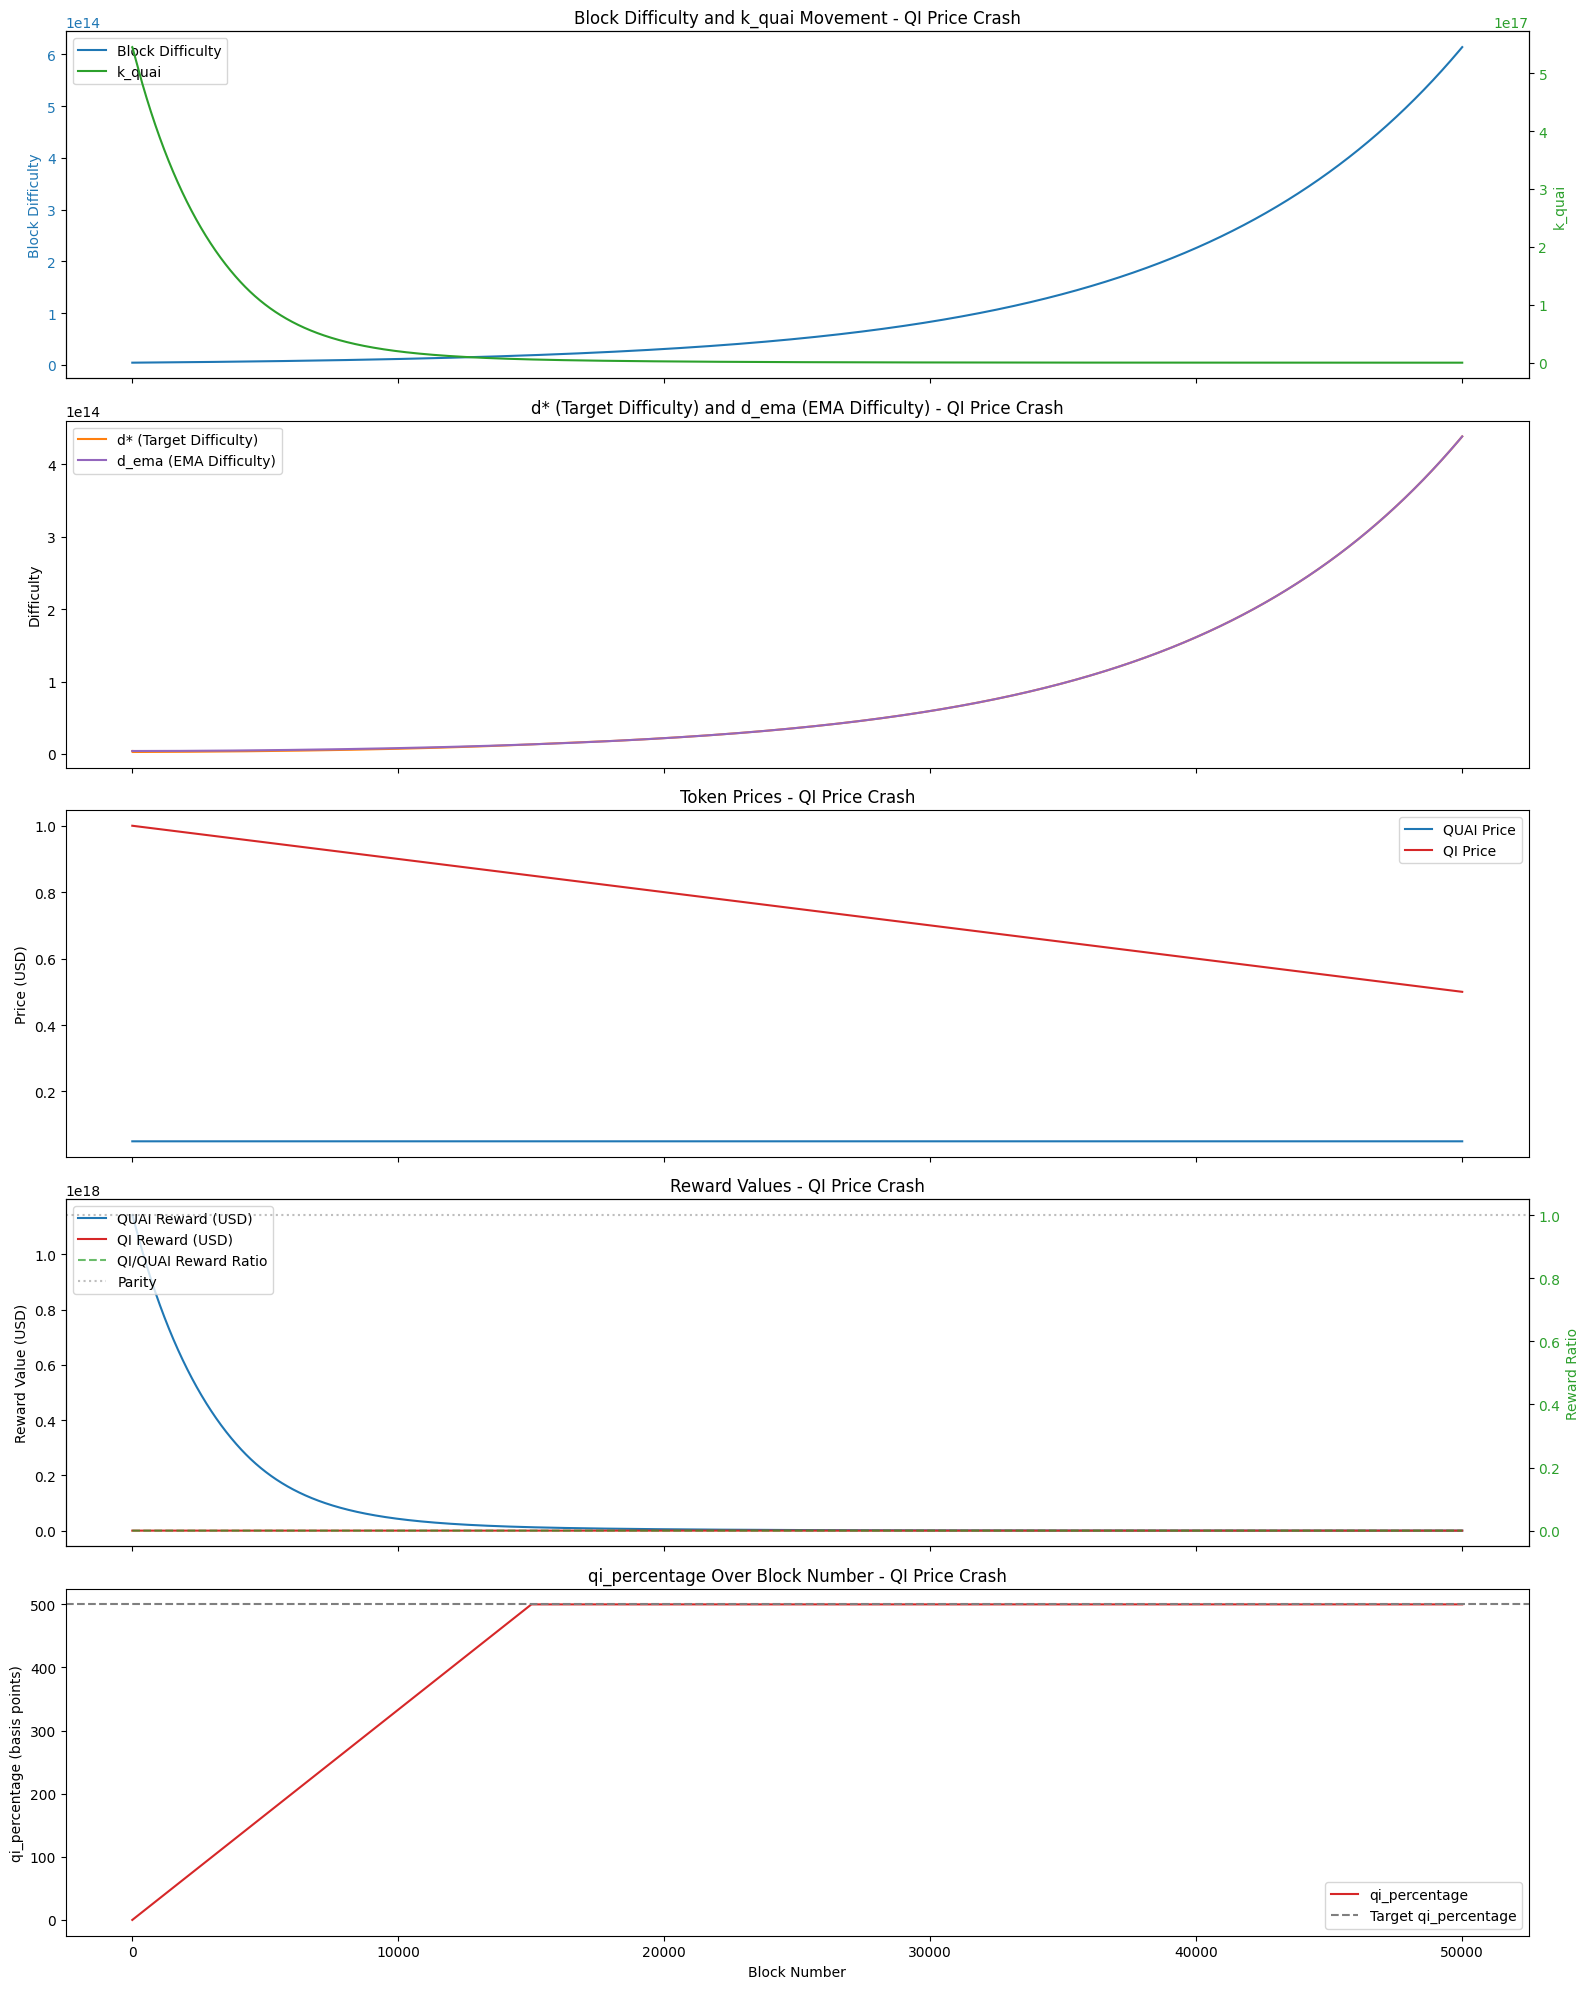


=== QI Price Crash Results ===
Initial k_quai: 5.45e+17
Final k_quai: 1.14e+13
Percentage change in k_quai: -100.00%
Initial emission per block: 2.28e+19
Final emission per block: 5.60e+14
Emission reduction: 1.00%
Final QUAI price: $0.0500
Final QI price: $0.5000
Final reward ratio (QI/QUAI): 0.0000
Average reward ratio: 0.0000
Running scenario 9/13: Sinusoidal Price Cycles...


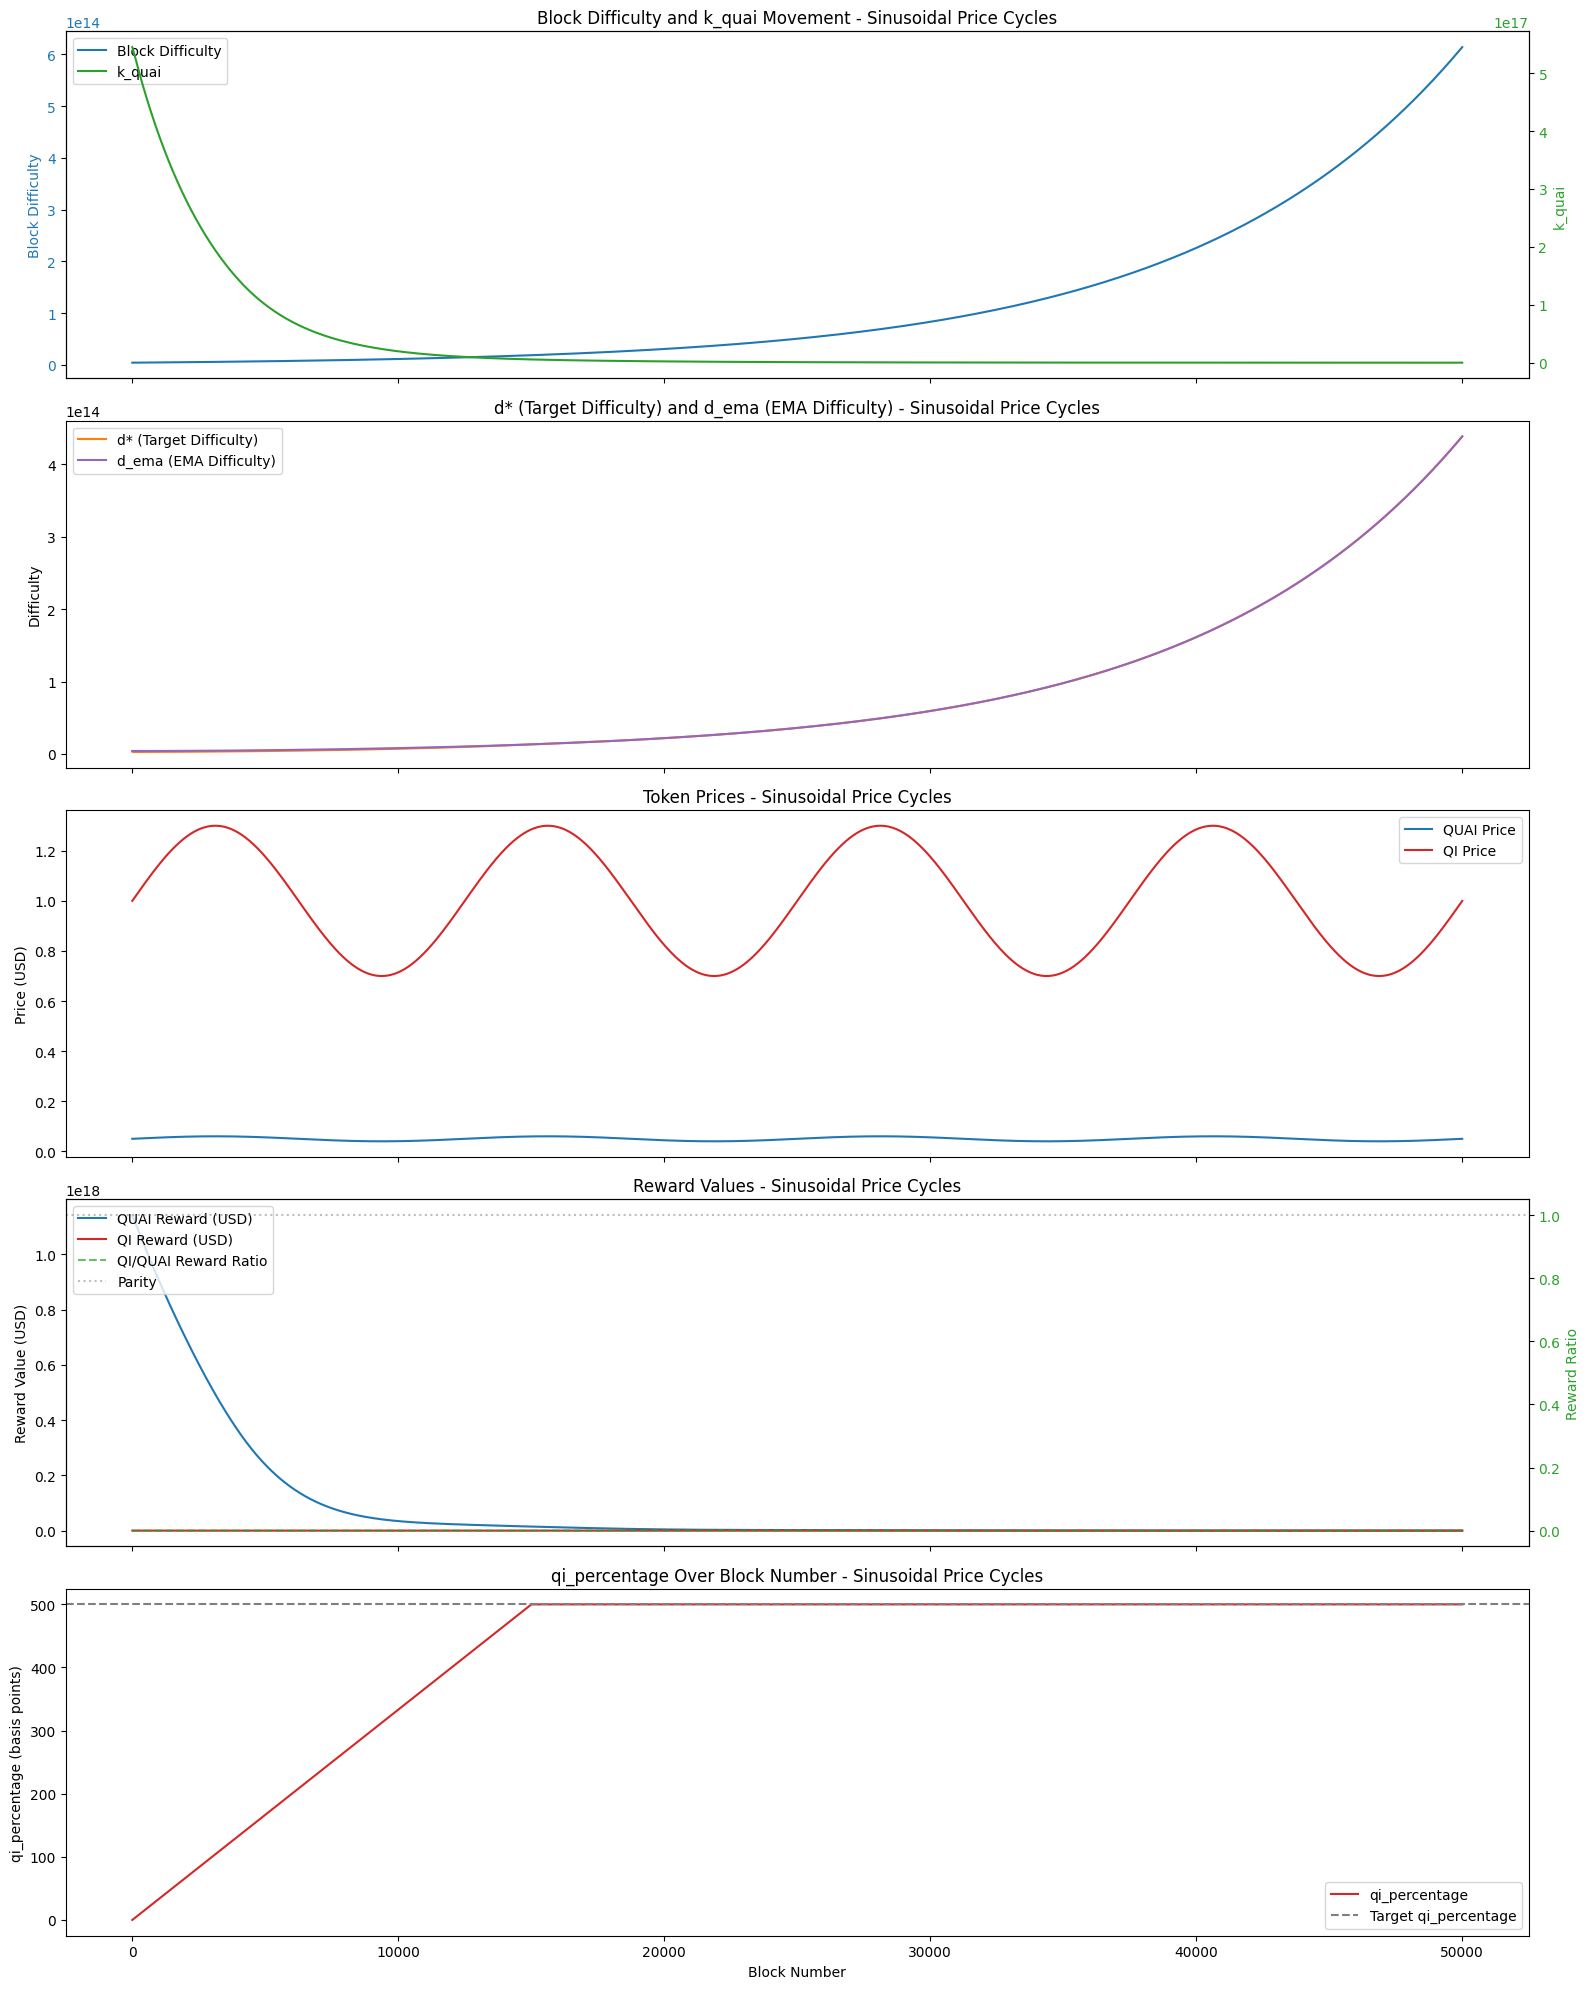


=== Sinusoidal Price Cycles Results ===
Initial k_quai: 5.45e+17
Final k_quai: 1.14e+13
Percentage change in k_quai: -100.00%
Initial emission per block: 2.28e+19
Final emission per block: 5.60e+14
Emission reduction: 1.00%
Final QUAI price: $0.0500
Final QI price: $0.9998
Final reward ratio (QI/QUAI): 0.0000
Average reward ratio: 0.0000
Running scenario 10/13: QI 10x Premium...


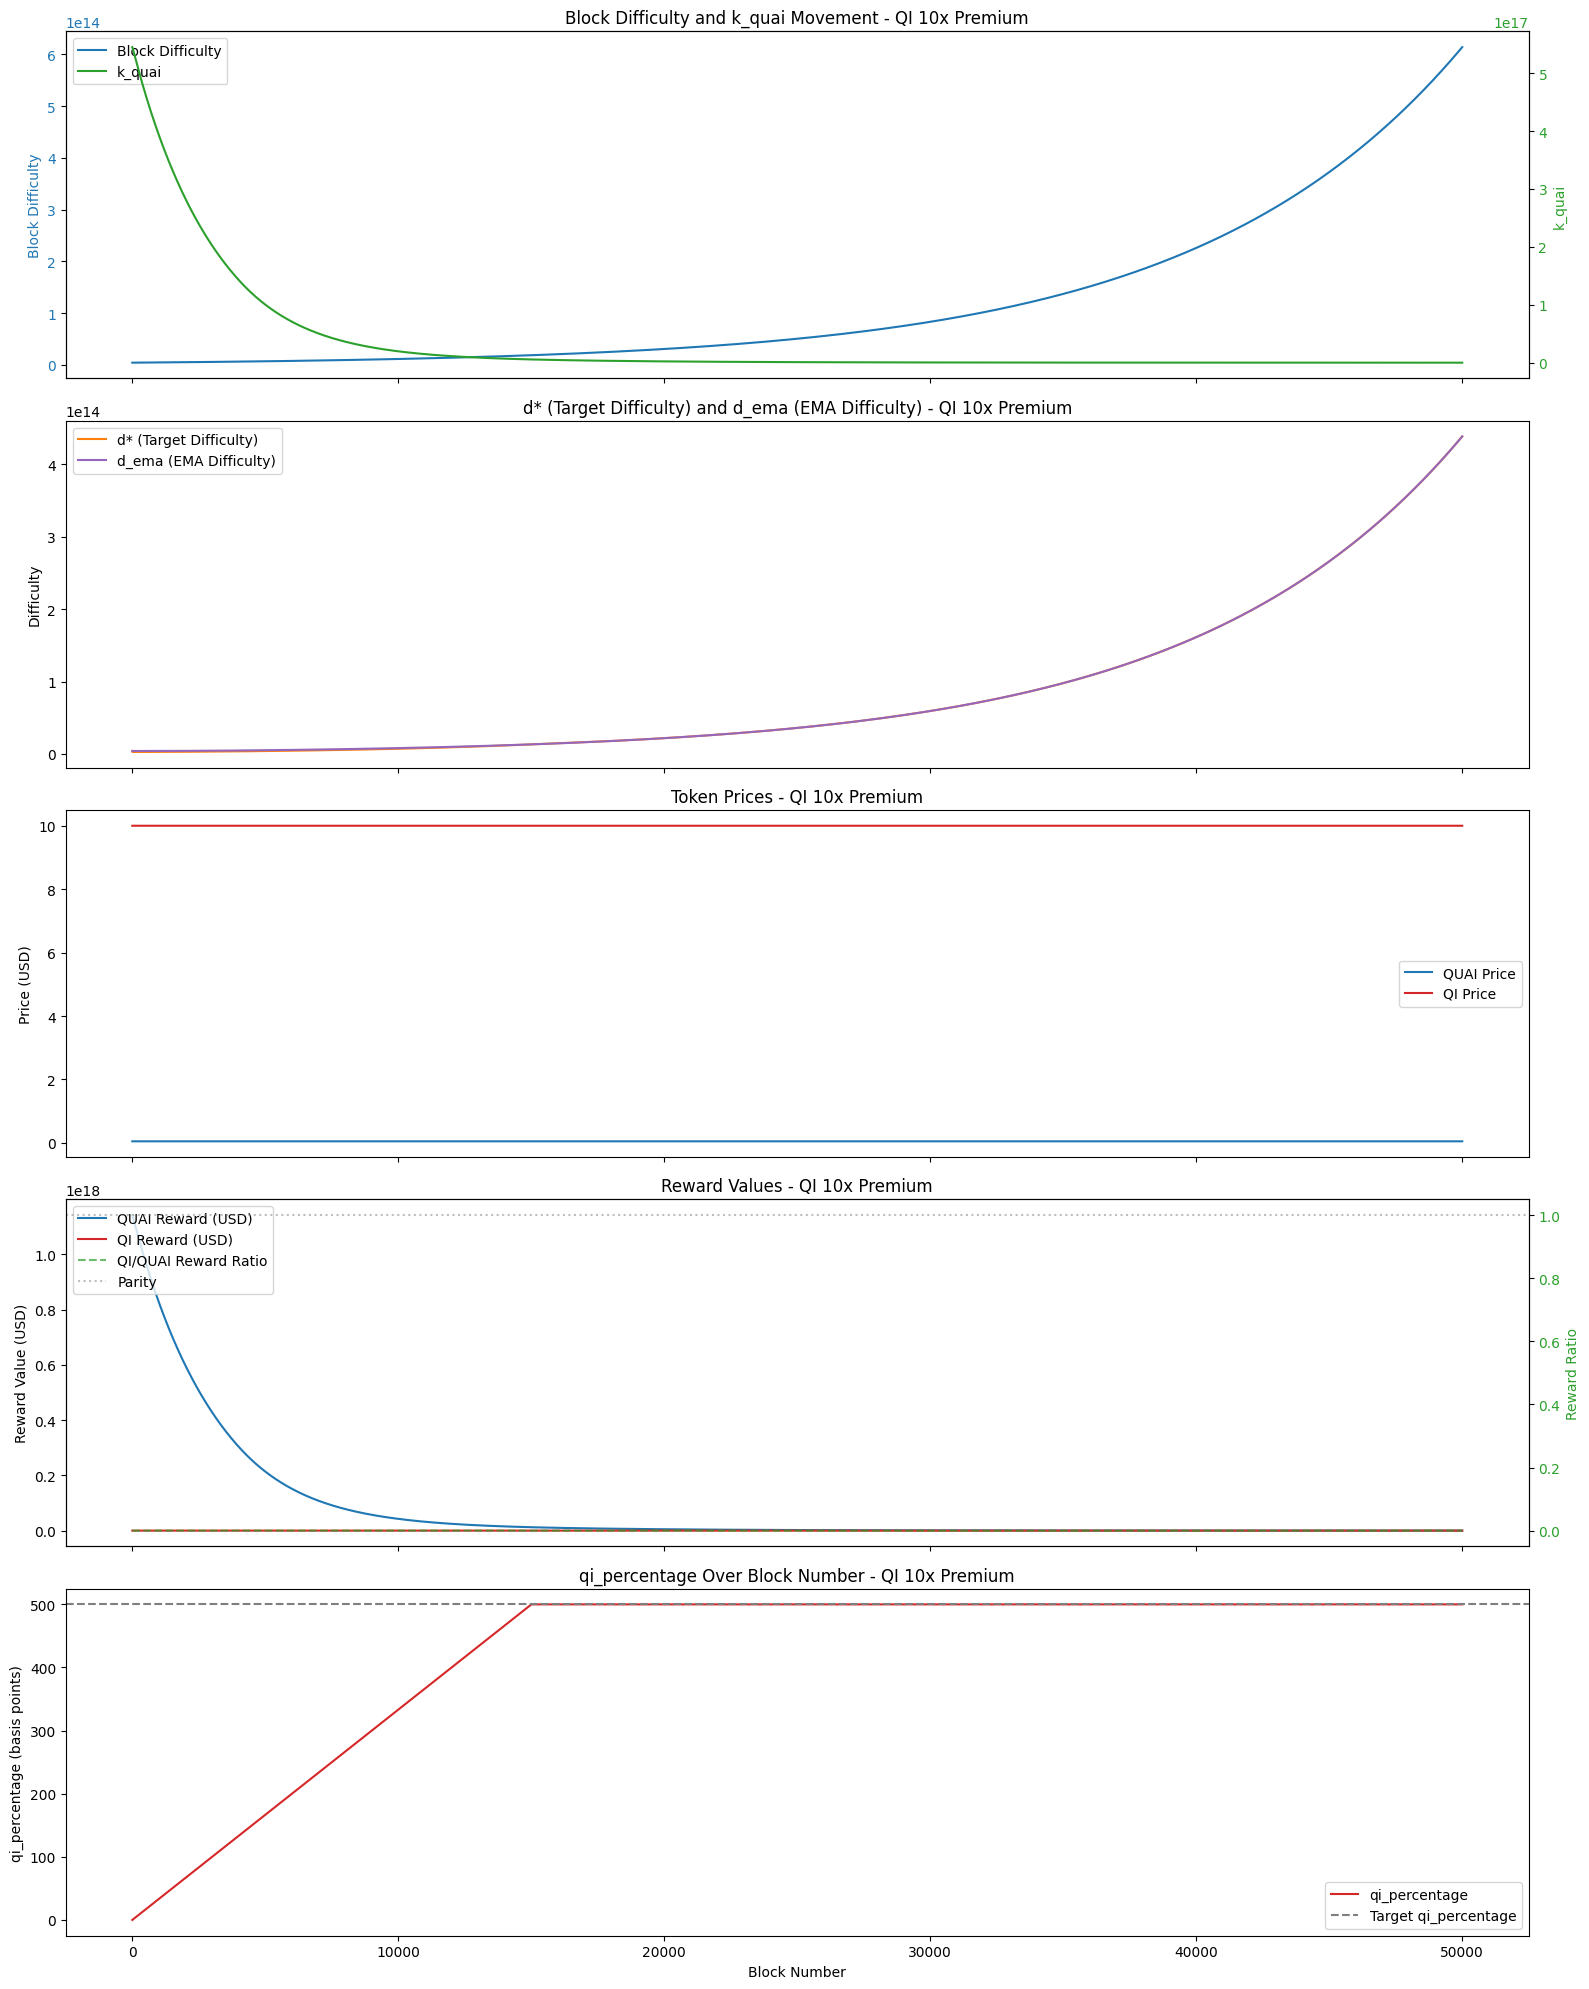


=== QI 10x Premium Results ===
Initial k_quai: 5.45e+17
Final k_quai: 1.14e+13
Percentage change in k_quai: -100.00%
Initial emission per block: 2.28e+19
Final emission per block: 5.60e+14
Emission reduction: 1.00%
Final QUAI price: $0.0500
Final QI price: $10.0000
Final reward ratio (QI/QUAI): 0.0000
Average reward ratio: 0.0000
Running scenario 11/13: High Price Volatility...


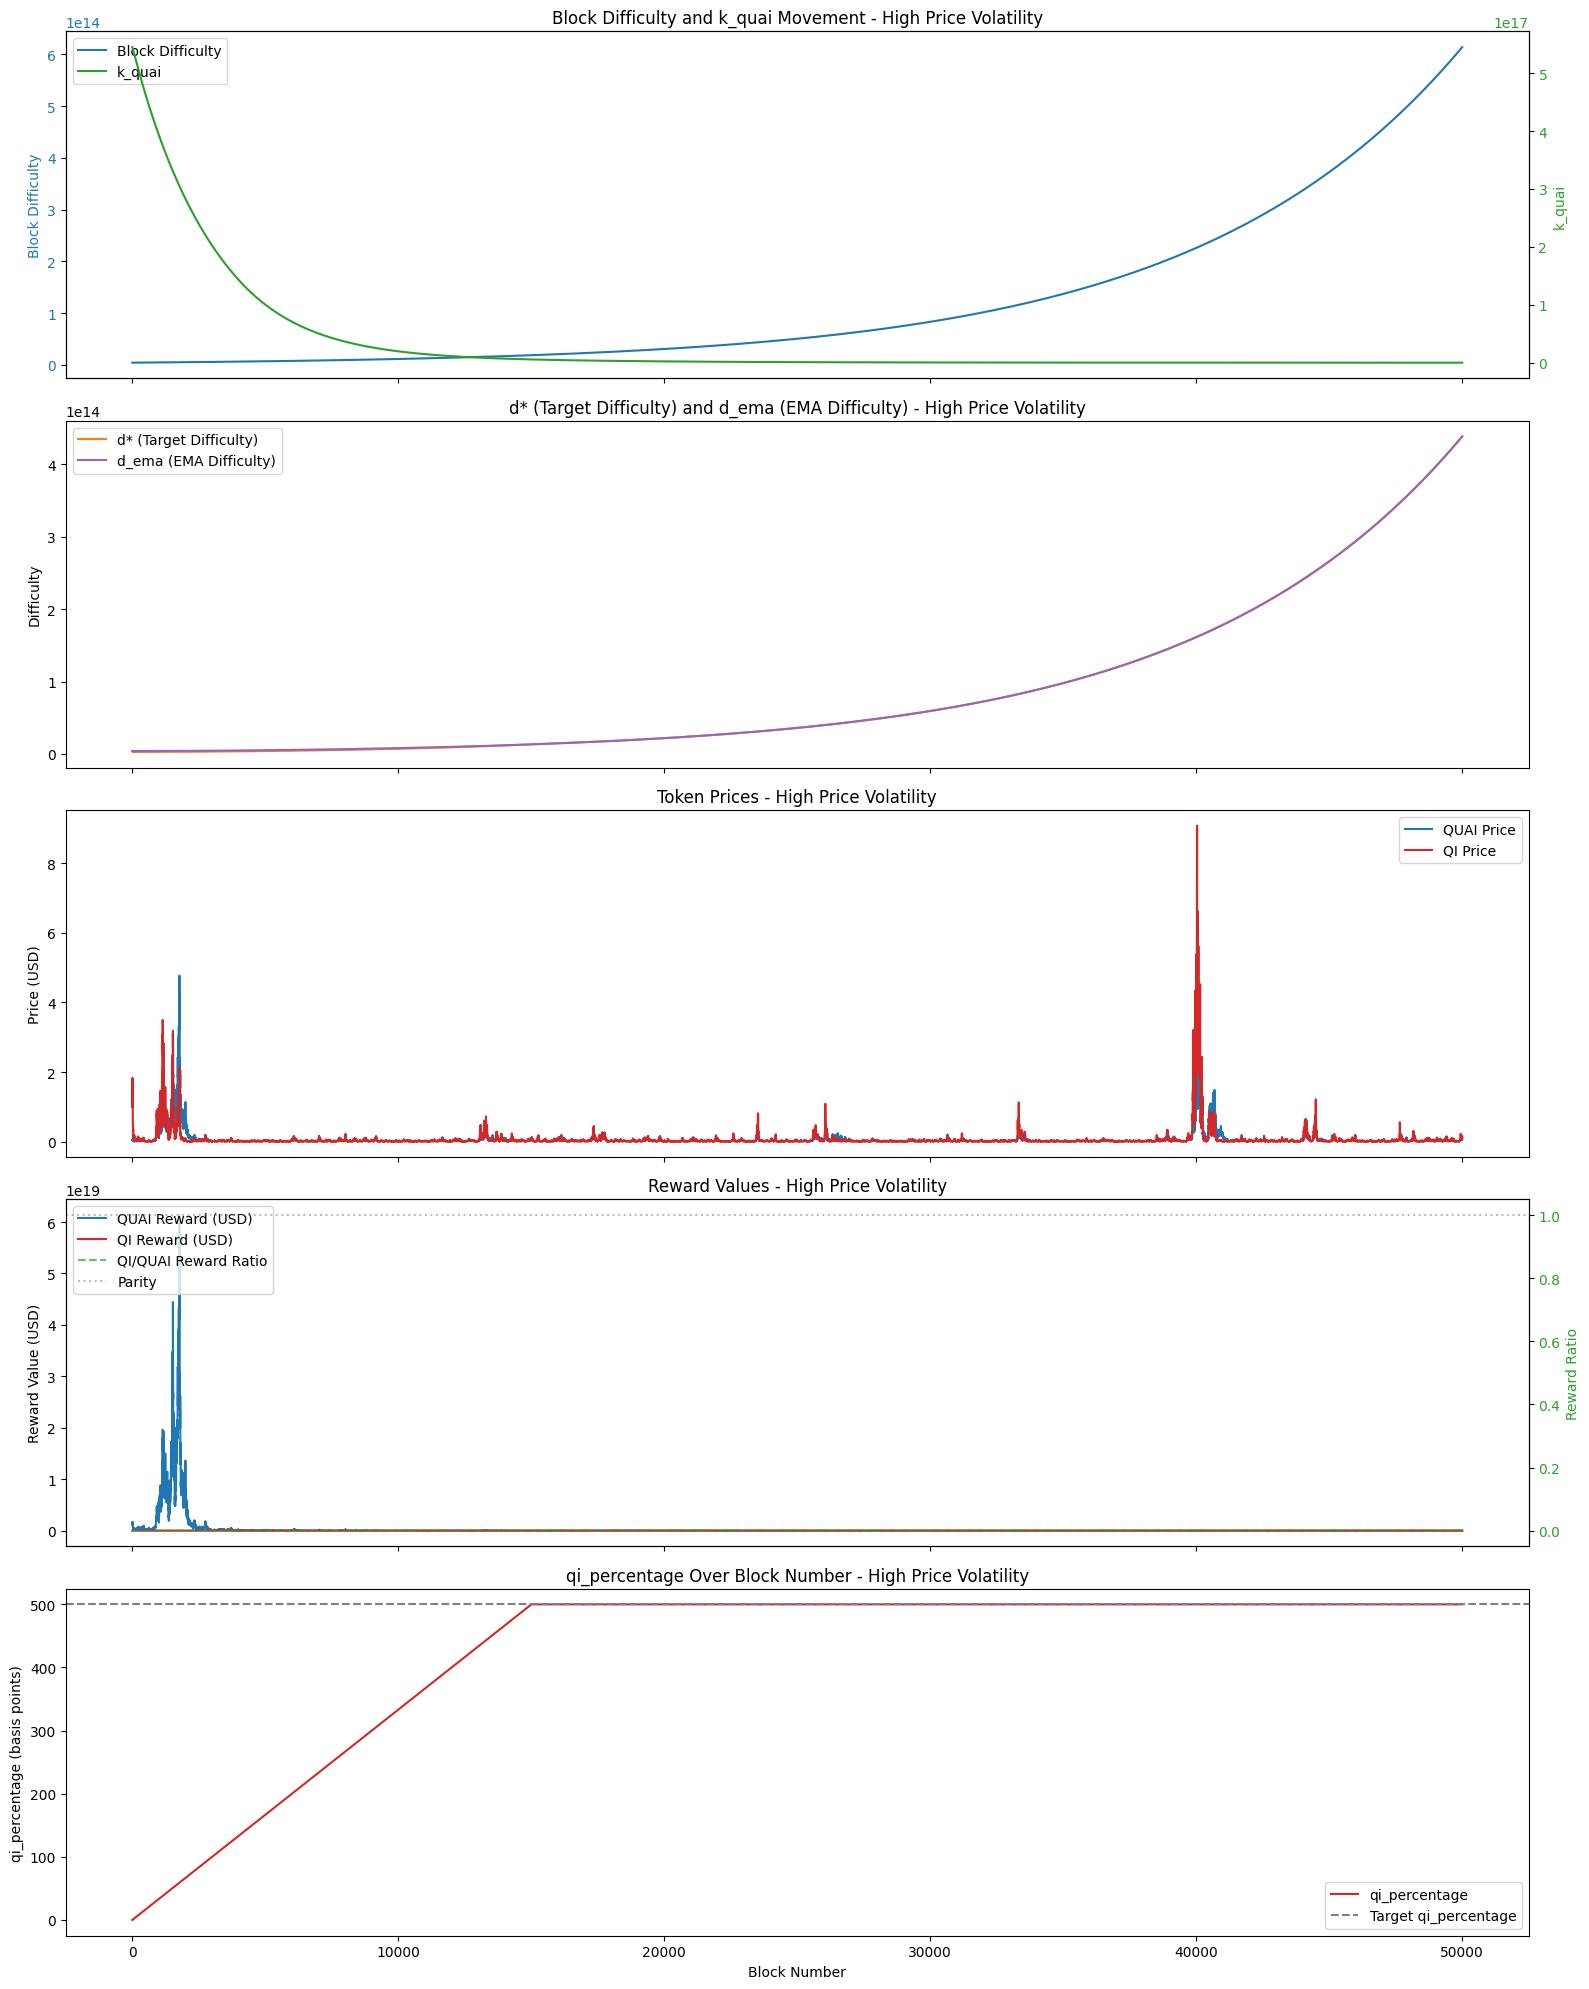


=== High Price Volatility Results ===
Initial k_quai: 5.45e+17
Final k_quai: 1.14e+13
Percentage change in k_quai: -100.00%
Initial emission per block: 2.28e+19
Final emission per block: 5.60e+14
Emission reduction: 1.00%
Final QUAI price: $0.0630
Final QI price: $0.1090
Final reward ratio (QI/QUAI): 0.0000
Average reward ratio: 0.0000
Running scenario 12/13: Rising QI + High Responsiveness...


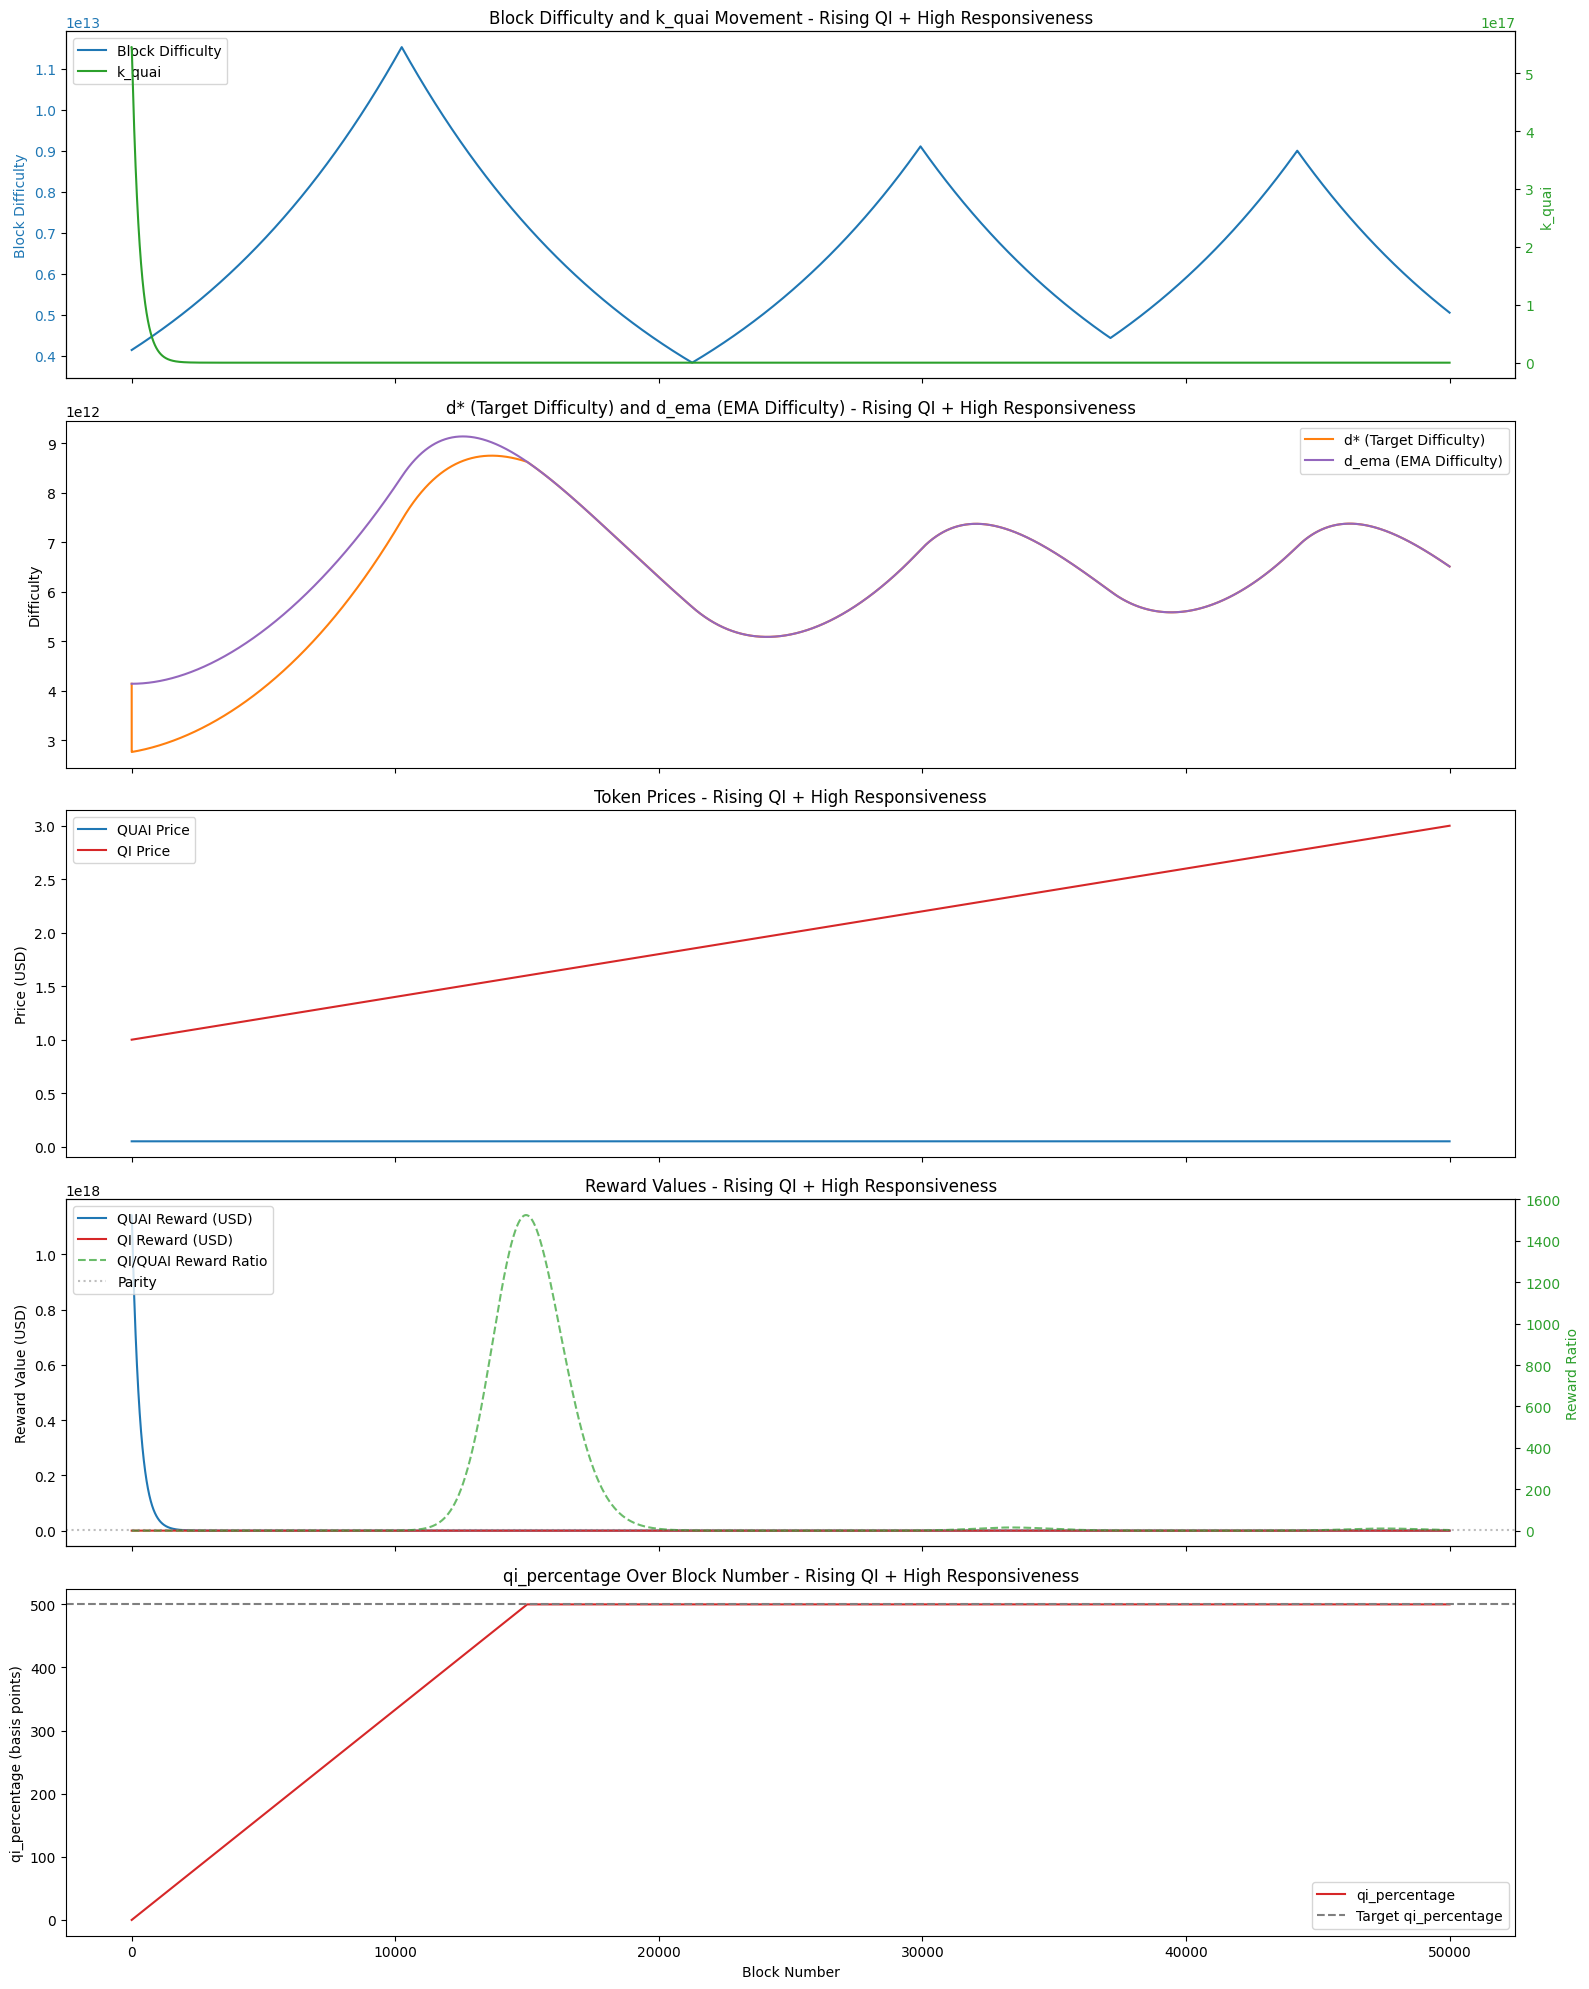


=== Rising QI + High Responsiveness Results ===
Initial k_quai: 5.45e+17
Final k_quai: 3.16e+02
Percentage change in k_quai: -100.00%
Initial emission per block: 2.28e+19
Final emission per block: 1.34e+04
Emission reduction: 1.00%
Final QUAI price: $0.0500
Final QI price: $3.0000
Final reward ratio (QI/QUAI): 2.8351
Average reward ratio: 102.8509
Running scenario 13/13: Quick Price Test...


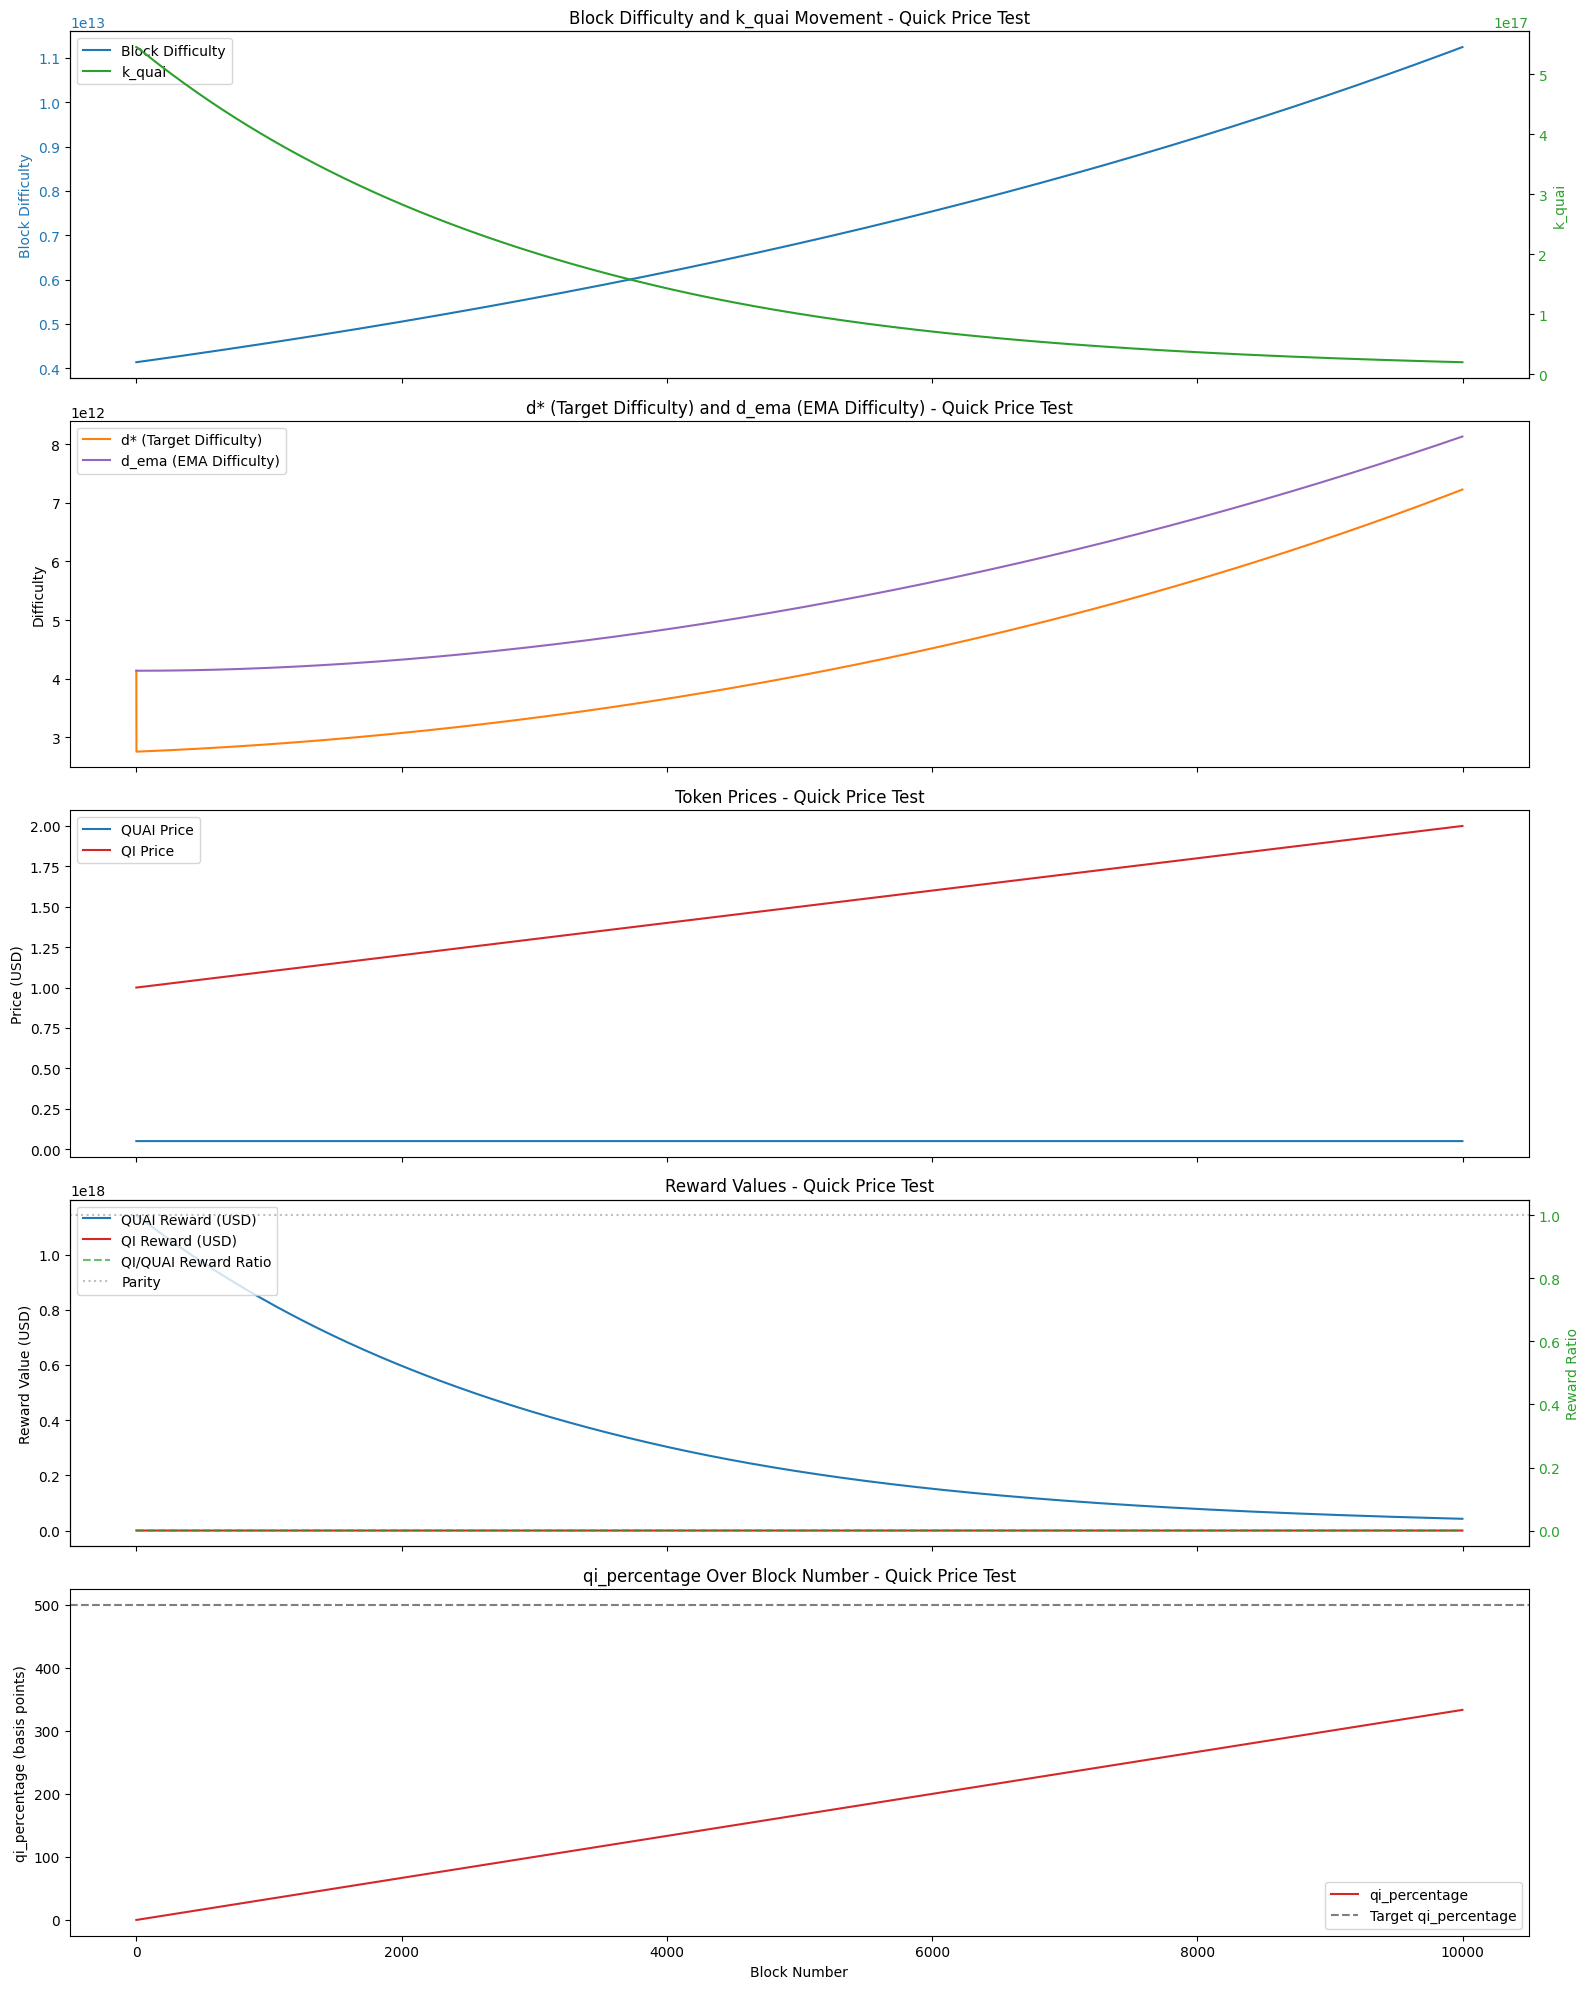


=== Quick Price Test Results ===
Initial k_quai: 5.45e+17
Final k_quai: 1.96e+16
Percentage change in k_quai: -96.40%
Initial emission per block: 2.28e+19
Final emission per block: 8.51e+17
Emission reduction: 0.96%
Final QUAI price: $0.0500
Final QI price: $1.9999
Final reward ratio (QI/QUAI): 0.0000
Average reward ratio: 0.0000

SCENARIO COMPARISON
                       Scenario final_k_quai percentage_change_k_quai emission_reduction_percentage final_reward_ratio avg_reward_ratio
     Baseline - Constant Prices     1.14e+13                -1.00e+02                         1.00%             0.0000           0.0000
                QI Price Rising     1.14e+13                -1.00e+02                         1.00%             0.0000           0.0000
              QUAI Price Rising     1.14e+13                -1.00e+02                         1.00%             0.0000           0.0000
             Both Prices Rising     1.14e+13                -1.00e+02                         1.00%   

[{'config': {'name': 'Baseline - Constant Prices',
   'adjustment_window': 4000,
   'num_blocks': 50000,
   'starting_difficulty': 4137588815064,
   'difficulty_growth_factor': 0.0001,
   'start_k_quai': 5.45e+17,
   'k_quai_alpha': 0.001,
   'target_qi_percentage': 500,
   'chosen_qi_percentage': 0,
   'qi_choice_alpha': 0.002,
   'quai_choices': 2000,
   'qi_choices': 2000,
   'slip': 0.1,
   'slip_alpha': 0.2,
   'qi_percentage_type': 'linear',
   'qi_percentage_custom': None,
   'quai_price_initial': 0.05,
   'qi_price_initial': 1.0,
   'quai_price_type': 'constant',
   'qi_price_type': 'constant',
   'quai_price_growth': 0.0,
   'qi_price_growth': 0.0,
   'quai_price_volatility': 0.0,
   'qi_price_volatility': 0.0,
   'quai_price_custom': None,
   'qi_price_custom': None},
  'block_difficulties': [4137588815064,
   4138002573945.5063,
   4138416374202.901,
   4138830215840.3213,
   4139244098861.9053,
   4139658023271.7915,
   4140071989074.1187,
   4140485996273.026,
   414090004

In [7]:
run_all_scenarios(scenarios=scenarios)